# Collaboration and Competition

---

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name='../apps/Tennis.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random
import copy
from collections import deque, namedtuple

In [5]:
# Helper Functions
def random_sample(indices, batch_size):
    indices = np.asarray(np.random.permutation(indices))
    batches = indices[:len(indices) // batch_size * batch_size].reshape(-1, batch_size)
    for batch in batches:
        yield batch
    r = len(indices) % batch_size
    if r:
        yield indices[-r:]

def stack_tensor(some_list):
    return torch.cat(some_list[:1000], dim=0)

In [6]:
# Models
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Critic(nn.Module):
    def __init__(self, seed):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(48, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, states):
        states = states.reshape(-1, 48)
        x = F.tanh(self.fc1(states))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    
class Actor(nn.Module):
    def __init__(self, seed):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(24, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 2)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, states):
        x = F.tanh(self.fc1(states))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x  
    
class ActorAndCritic(nn.Module):
    def __init__(self, seed):
        super(ActorAndCritic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.sd = nn.Parameter(torch.zeros(2))
        self.actor = Actor(1)
        self.critic = Critic(1)
        
    def forward(self, states, states_part):
        mean = self.actor(states_part)
        values = self.critic(states)
        dist = torch.distributions.Normal(mean, F.softplus(self.sd))
        actions = torch.clamp(dist.sample(), -1, 1)
        if len(actions) == 2:
            actions = actions.unsqueeze(0)
        return actions.squeeze(0), values.squeeze(0), dist.log_prob(actions).mean(1), dist

In [7]:
class Agent(nn.Module):
    def __init__(self):
        super(Agent, self).__init__()
        self.network = ActorAndCritic(5)
        self.optimizer = optim.Adam(self.network.parameters(), lr = 5e-5)
    
    def act(self, states, states_part):
        with torch.no_grad():
            actions, values, log_probs, dist = self.network(states, states_part)
        return actions, values, log_probs, dist
    
    def step(self, old_log_probs, states, states_part, actions, rewards, dones, values, advantages, returns, mean_score):
        if mean_score>=0.80:
            epoch = 1
        elif mean_score>=0.40:
            epoch = 3
        elif mean_score>=0.20:
            epoch = 5
        else:
            epoch = 10
        for e in range(epoch):
            samples = random_sample(np.arange(500), 100)
            for sample in samples:
                states_1 = states[sample]
                states_part_1 = states_part[sample]
                actions_1 = actions[sample]
                old_log_probs_1 = old_log_probs[sample]
                advantages_1 = advantages[sample]
                returns_1 = returns[sample]
                
                _, values_1, _, dist = self.network(states_1, states_part_1)
                new_log_probs_1 = dist.log_prob(actions_1).mean(1).unsqueeze(1)

                new_probs, old_probs = torch.exp(new_log_probs_1), torch.exp(old_log_probs_1)
                ratios = new_probs / old_probs
                ratios_clipped = torch.clamp(ratios, 0.9, 1.1)
                entropy = -(new_probs * torch.log(old_probs + 1e-10) + (1.0 - new_probs) * torch.log(1.0 - old_probs + 1e-10))
                entropy[torch.isnan(entropy)] = 0
                
                rewards_clipped = -torch.min(ratios * advantages_1, ratios_clipped * advantages_1)
                rewards_clipped = torch.mean(rewards_clipped + 0.01 * entropy)
                loss = torch.mean((returns_1 - values_1)**2)
                total_loss = rewards_clipped + 2 * loss
                
                self.optimizer.zero_grad()
                total_loss.backward()
                nn.utils.clip_grad_norm_(self.network.parameters(), 10) 
                self.optimizer.step()

In [8]:
class MAPPO(nn.Module):
    def __init__(self):
        super(MAPPO, self).__init__()
        self.mappo = [Agent(), Agent()]
    
    def act(self, states):
        actions0, values0, log_probs0, _ = self.mappo[0].act(states, states[0])
        actions1, values1, log_probs1, _ = self.mappo[1].act(states, states[1])
        return torch.stack((actions0, actions1)), torch.stack((values0, values1)), torch.stack((log_probs0, log_probs1))
 
    def step(self, old_log_probs, states, actions, rewards, dones, values, mean_score):
        rewards = torch.tensor(rewards, dtype = torch.float).unsqueeze(2)
        dones = torch.tensor(dones, dtype = torch.int).unsqueeze(2)
        
        advantages = [0.0] * 500
        returns = [0.0] * 500
        advantage = torch.zeros((2, 1))
        return_ = torch.zeros((2, 1))
        for i in reversed(range(500)):
            if i == 500 - 1:
                td = (rewards[i] - values[i]).squeeze(0)
            else:
                td = (rewards[i] + (0.99 * (1-dones[i]) * values[i + 1]) - values[i]).squeeze(0)
            advantage = advantage * 0.95 * 0.99 * (1-dones[i]) + td
            return_ = rewards[i] + 0.99 * (1-dones[i]) * return_           
            advantages[i] = advantage
            returns[i] = return_
            
        old_log_probs, states, actions, values, advantages, returns = \
        torch.stack(old_log_probs), torch.stack(states), torch.stack(actions), \
        torch.stack(values), torch.stack(advantages), torch.stack(returns)
        advantages = torch.clamp((advantages - advantages.mean()) / advantages.std(), -1e5, 1e5)
        
        for i, mappo in enumerate(self.mappo):
            mappo.step(old_log_probs[:,i,:], states, states[:,i,:], actions[:,i,:], rewards[:,i,:], dones[:,i,:], values[:,i,:], advantages[:,i,:], returns[:,i,:], mean_score)
            
mappo = MAPPO()

In [9]:
scores = []
scores_window = deque(maxlen=100)
log_probs_all, states_all, actions_all, rewards_all, dones_all, values_all = [], [], [], [], [], []
sample_num = 0
scores_window_3 = deque(maxlen=3)
for i in range(15000):                                         
    env_info = env.reset(train_mode=True)[brain_name]     
    states = torch.tensor(env_info.vector_observations, dtype = torch.float)
    score = np.zeros(num_agents) 
    while True:
        actions, values, log_probs = mappo.act(states)
        env_info = env.step(actions.detach().numpy())[brain_name]           
        next_states = torch.tensor(env_info.vector_observations, dtype = torch.float)
        dones = env_info.local_done
        
        log_probs_all.append(log_probs)
        states_all.append(states)
        actions_all.append(actions)
        rewards_all.append(env_info.rewards)
        dones_all.append(dones)
        values_all.append(values)
        score += env_info.rewards
        states = next_states 
        
        if sample_num == 499 and np.mean(scores_window_3)<1.2:
            mappo.step(log_probs_all, states_all, actions_all, rewards_all, dones_all, values_all, np.mean(scores_window))
            log_probs_all, states_all, actions_all, rewards_all, dones_all, values_all = [], [], [], [], [], []
        
        sample_num = (sample_num + 1) % 500
        if np.any(dones):                                  
            break
               
    scores.append(np.max(score))
    scores_window.append(np.max(score))
    scores_window_3.append(np.max(score))
    print('\rEpisode {}\tReward: {:.5f}\tAverage Reward: {:.5f}'.format(i, np.max(score), np.mean(scores_window)))
    if np.mean(scores_window) >= 1.2:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i-100, np.mean(scores_window)))
        torch.save(mappo.mappo[0].network.state_dict(), 'checkpoint/trained_weights_mappo_p1.pth')
        torch.save(mappo.mappo[1].network.state_dict(), 'checkpoint/trained_weights_mappo_p2.pth')
        break

/anaconda3/envs/reacher_ddpg/lib/python3.6/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 0	Reward: 0.00000	Average Reward: 0.00000
Episode 1	Reward: 0.00000	Average Reward: 0.00000
Episode 2	Reward: 0.10000	Average Reward: 0.03333
Episode 3	Reward: 0.00000	Average Reward: 0.02500
Episode 4	Reward: 0.00000	Average Reward: 0.02000
Episode 5	Reward: 0.10000	Average Reward: 0.03333
Episode 6	Reward: 0.00000	Average Reward: 0.02857
Episode 7	Reward: 0.00000	Average Reward: 0.02500
Episode 8	Reward: 0.00000	Average Reward: 0.02222
Episode 9	Reward: 0.09000	Average Reward: 0.02900
Episode 10	Reward: 0.00000	Average Reward: 0.02636
Episode 11	Reward: 0.09000	Average Reward: 0.03167
Episode 12	Reward: 0.00000	Average Reward: 0.02923
Episode 13	Reward: 0.10000	Average Reward: 0.03429
Episode 14	Reward: 0.00000	Average Reward: 0.03200
Episode 15	Reward: 0.09000	Average Reward: 0.03563
Episode 16	Reward: 0.00000	Average Reward: 0.03353
Episode 17	Reward: 0.00000	Average Reward: 0.03167
Episode 18	Reward: 0.00000	Average Reward: 0.03000
Episode 19	Reward: 0.00000	Average Reward

Episode 161	Reward: 0.00000	Average Reward: 0.01440
Episode 162	Reward: 0.10000	Average Reward: 0.01540
Episode 163	Reward: 0.10000	Average Reward: 0.01640
Episode 164	Reward: 0.00000	Average Reward: 0.01640
Episode 165	Reward: 0.00000	Average Reward: 0.01550
Episode 166	Reward: 0.00000	Average Reward: 0.01550
Episode 167	Reward: 0.00000	Average Reward: 0.01460
Episode 168	Reward: 0.00000	Average Reward: 0.01460
Episode 169	Reward: 0.00000	Average Reward: 0.01460
Episode 170	Reward: 0.00000	Average Reward: 0.01360
Episode 171	Reward: 0.00000	Average Reward: 0.01360
Episode 172	Reward: 0.10000	Average Reward: 0.01460
Episode 173	Reward: 0.00000	Average Reward: 0.01460
Episode 174	Reward: 0.00000	Average Reward: 0.01460
Episode 175	Reward: 0.10000	Average Reward: 0.01460
Episode 176	Reward: 0.00000	Average Reward: 0.01460
Episode 177	Reward: 0.00000	Average Reward: 0.01460
Episode 178	Reward: 0.00000	Average Reward: 0.01460
Episode 179	Reward: 0.00000	Average Reward: 0.01460
Episode 180	

Episode 322	Reward: 0.00000	Average Reward: 0.02780
Episode 323	Reward: 0.00000	Average Reward: 0.02780
Episode 324	Reward: 0.00000	Average Reward: 0.02780
Episode 325	Reward: 0.00000	Average Reward: 0.02780
Episode 326	Reward: 0.09000	Average Reward: 0.02770
Episode 327	Reward: 0.09000	Average Reward: 0.02760
Episode 328	Reward: 0.00000	Average Reward: 0.02760
Episode 329	Reward: 0.00000	Average Reward: 0.02760
Episode 330	Reward: 0.00000	Average Reward: 0.02660
Episode 331	Reward: 0.00000	Average Reward: 0.02660
Episode 332	Reward: 0.00000	Average Reward: 0.02660
Episode 333	Reward: 0.09000	Average Reward: 0.02750
Episode 334	Reward: 0.00000	Average Reward: 0.02750
Episode 335	Reward: 0.09000	Average Reward: 0.02740
Episode 336	Reward: 0.00000	Average Reward: 0.02740
Episode 337	Reward: 0.10000	Average Reward: 0.02840
Episode 338	Reward: 0.00000	Average Reward: 0.02840
Episode 339	Reward: 0.10000	Average Reward: 0.02850
Episode 340	Reward: 0.00000	Average Reward: 0.02750
Episode 341	

Episode 481	Reward: 0.09000	Average Reward: 0.02880
Episode 482	Reward: 0.00000	Average Reward: 0.02780
Episode 483	Reward: 0.09000	Average Reward: 0.02770
Episode 484	Reward: 0.00000	Average Reward: 0.02770
Episode 485	Reward: 0.00000	Average Reward: 0.02770
Episode 486	Reward: 0.10000	Average Reward: 0.02780
Episode 487	Reward: 0.00000	Average Reward: 0.02690
Episode 488	Reward: 0.00000	Average Reward: 0.02690
Episode 489	Reward: 0.00000	Average Reward: 0.02690
Episode 490	Reward: 0.00000	Average Reward: 0.02690
Episode 491	Reward: 0.10000	Average Reward: 0.02790
Episode 492	Reward: 0.00000	Average Reward: 0.02790
Episode 493	Reward: 0.00000	Average Reward: 0.02700
Episode 494	Reward: 0.00000	Average Reward: 0.02700
Episode 495	Reward: 0.09000	Average Reward: 0.02790
Episode 496	Reward: 0.00000	Average Reward: 0.02790
Episode 497	Reward: 0.09000	Average Reward: 0.02780
Episode 498	Reward: 0.10000	Average Reward: 0.02790
Episode 499	Reward: 0.09000	Average Reward: 0.02880
Episode 500	

Episode 641	Reward: 0.00000	Average Reward: 0.02650
Episode 642	Reward: 0.00000	Average Reward: 0.02650
Episode 643	Reward: 0.00000	Average Reward: 0.02650
Episode 644	Reward: 0.10000	Average Reward: 0.02750
Episode 645	Reward: 0.09000	Average Reward: 0.02840
Episode 646	Reward: 0.00000	Average Reward: 0.02840
Episode 647	Reward: 0.09000	Average Reward: 0.02840
Episode 648	Reward: 0.00000	Average Reward: 0.02740
Episode 649	Reward: 0.00000	Average Reward: 0.02740
Episode 650	Reward: 0.00000	Average Reward: 0.02740
Episode 651	Reward: 0.00000	Average Reward: 0.02650
Episode 652	Reward: 0.00000	Average Reward: 0.02650
Episode 653	Reward: 0.00000	Average Reward: 0.02650
Episode 654	Reward: 0.00000	Average Reward: 0.02650
Episode 655	Reward: 0.00000	Average Reward: 0.02650
Episode 656	Reward: 0.10000	Average Reward: 0.02550
Episode 657	Reward: 0.10000	Average Reward: 0.02650
Episode 658	Reward: 0.00000	Average Reward: 0.02550
Episode 659	Reward: 0.10000	Average Reward: 0.02550
Episode 660	

Episode 799	Reward: 0.10000	Average Reward: 0.03340
Episode 800	Reward: 0.10000	Average Reward: 0.03440
Episode 801	Reward: 0.00000	Average Reward: 0.03440
Episode 802	Reward: 0.20000	Average Reward: 0.03540
Episode 803	Reward: 0.10000	Average Reward: 0.03440
Episode 804	Reward: 0.10000	Average Reward: 0.03540
Episode 805	Reward: 0.00000	Average Reward: 0.03540
Episode 806	Reward: 0.00000	Average Reward: 0.03540
Episode 807	Reward: 0.00000	Average Reward: 0.03540
Episode 808	Reward: 0.00000	Average Reward: 0.03440
Episode 809	Reward: 0.09000	Average Reward: 0.03430
Episode 810	Reward: 0.00000	Average Reward: 0.03430
Episode 811	Reward: 0.09000	Average Reward: 0.03520
Episode 812	Reward: 0.10000	Average Reward: 0.03620
Episode 813	Reward: 0.00000	Average Reward: 0.03620
Episode 814	Reward: 0.00000	Average Reward: 0.03620
Episode 815	Reward: 0.20000	Average Reward: 0.03820
Episode 816	Reward: 0.10000	Average Reward: 0.03820
Episode 817	Reward: 0.00000	Average Reward: 0.03820
Episode 818	

Episode 957	Reward: 0.00000	Average Reward: 0.03950
Episode 958	Reward: 0.10000	Average Reward: 0.04050
Episode 959	Reward: 0.00000	Average Reward: 0.03950
Episode 960	Reward: 0.00000	Average Reward: 0.03850
Episode 961	Reward: 0.10000	Average Reward: 0.03950
Episode 962	Reward: 0.09000	Average Reward: 0.04040
Episode 963	Reward: 0.00000	Average Reward: 0.04040
Episode 964	Reward: 0.10000	Average Reward: 0.04140
Episode 965	Reward: 0.09000	Average Reward: 0.04140
Episode 966	Reward: 0.10000	Average Reward: 0.04150
Episode 967	Reward: 0.09000	Average Reward: 0.04240
Episode 968	Reward: 0.00000	Average Reward: 0.04240
Episode 969	Reward: 0.00000	Average Reward: 0.04240
Episode 970	Reward: 0.00000	Average Reward: 0.04240
Episode 971	Reward: 0.10000	Average Reward: 0.04340
Episode 972	Reward: 0.00000	Average Reward: 0.04340
Episode 973	Reward: 0.09000	Average Reward: 0.04330
Episode 974	Reward: 0.00000	Average Reward: 0.04330
Episode 975	Reward: 0.00000	Average Reward: 0.04230
Episode 976	

Episode 1114	Reward: 0.09000	Average Reward: 0.03670
Episode 1115	Reward: 0.00000	Average Reward: 0.03670
Episode 1116	Reward: 0.00000	Average Reward: 0.03580
Episode 1117	Reward: 0.00000	Average Reward: 0.03580
Episode 1118	Reward: 0.00000	Average Reward: 0.03580
Episode 1119	Reward: 0.10000	Average Reward: 0.03480
Episode 1120	Reward: 0.00000	Average Reward: 0.03390
Episode 1121	Reward: 0.10000	Average Reward: 0.03390
Episode 1122	Reward: 0.10000	Average Reward: 0.03490
Episode 1123	Reward: 0.00000	Average Reward: 0.03490
Episode 1124	Reward: 0.10000	Average Reward: 0.03590
Episode 1125	Reward: 0.00000	Average Reward: 0.03590
Episode 1126	Reward: 0.09000	Average Reward: 0.03680
Episode 1127	Reward: 0.00000	Average Reward: 0.03590
Episode 1128	Reward: 0.00000	Average Reward: 0.03490
Episode 1129	Reward: 0.00000	Average Reward: 0.03490
Episode 1130	Reward: 0.00000	Average Reward: 0.03390
Episode 1131	Reward: 0.10000	Average Reward: 0.03490
Episode 1132	Reward: 0.10000	Average Reward: 0

Episode 1271	Reward: 0.00000	Average Reward: 0.04740
Episode 1272	Reward: 0.10000	Average Reward: 0.04840
Episode 1273	Reward: 0.00000	Average Reward: 0.04740
Episode 1274	Reward: 0.00000	Average Reward: 0.04640
Episode 1275	Reward: 0.10000	Average Reward: 0.04640
Episode 1276	Reward: 0.10000	Average Reward: 0.04650
Episode 1277	Reward: 0.00000	Average Reward: 0.04650
Episode 1278	Reward: 0.00000	Average Reward: 0.04560
Episode 1279	Reward: 0.10000	Average Reward: 0.04660
Episode 1280	Reward: 0.00000	Average Reward: 0.04560
Episode 1281	Reward: 0.00000	Average Reward: 0.04470
Episode 1282	Reward: 0.10000	Average Reward: 0.04480
Episode 1283	Reward: 0.20000	Average Reward: 0.04680
Episode 1284	Reward: 0.10000	Average Reward: 0.04780
Episode 1285	Reward: 0.00000	Average Reward: 0.04680
Episode 1286	Reward: 0.10000	Average Reward: 0.04780
Episode 1287	Reward: 0.10000	Average Reward: 0.04880
Episode 1288	Reward: 0.10000	Average Reward: 0.04880
Episode 1289	Reward: 0.00000	Average Reward: 0

Episode 1427	Reward: 0.10000	Average Reward: 0.05730
Episode 1428	Reward: 0.10000	Average Reward: 0.05830
Episode 1429	Reward: 0.09000	Average Reward: 0.05920
Episode 1430	Reward: 0.00000	Average Reward: 0.05820
Episode 1431	Reward: 0.00000	Average Reward: 0.05730
Episode 1432	Reward: 0.00000	Average Reward: 0.05630
Episode 1433	Reward: 0.09000	Average Reward: 0.05630
Episode 1434	Reward: 0.00000	Average Reward: 0.05440
Episode 1435	Reward: 0.00000	Average Reward: 0.05240
Episode 1436	Reward: 0.00000	Average Reward: 0.05140
Episode 1437	Reward: 0.00000	Average Reward: 0.05050
Episode 1438	Reward: 0.00000	Average Reward: 0.05050
Episode 1439	Reward: 0.00000	Average Reward: 0.04950
Episode 1440	Reward: 0.00000	Average Reward: 0.04850
Episode 1441	Reward: 0.00000	Average Reward: 0.04850
Episode 1442	Reward: 0.00000	Average Reward: 0.04850
Episode 1443	Reward: 0.10000	Average Reward: 0.04950
Episode 1444	Reward: 0.00000	Average Reward: 0.04850
Episode 1445	Reward: 0.09000	Average Reward: 0

Episode 1582	Reward: 0.10000	Average Reward: 0.06530
Episode 1583	Reward: 0.00000	Average Reward: 0.06430
Episode 1584	Reward: 0.00000	Average Reward: 0.06330
Episode 1585	Reward: 0.10000	Average Reward: 0.06330
Episode 1586	Reward: 0.00000	Average Reward: 0.06230
Episode 1587	Reward: 0.20000	Average Reward: 0.06330
Episode 1588	Reward: 0.09000	Average Reward: 0.06330
Episode 1589	Reward: 0.00000	Average Reward: 0.06330
Episode 1590	Reward: 0.00000	Average Reward: 0.06230
Episode 1591	Reward: 0.00000	Average Reward: 0.06230
Episode 1592	Reward: 0.00000	Average Reward: 0.06230
Episode 1593	Reward: 0.09000	Average Reward: 0.06230
Episode 1594	Reward: 0.10000	Average Reward: 0.06130
Episode 1595	Reward: 0.00000	Average Reward: 0.06040
Episode 1596	Reward: 0.00000	Average Reward: 0.05950
Episode 1597	Reward: 0.00000	Average Reward: 0.05850
Episode 1598	Reward: 0.00000	Average Reward: 0.05850
Episode 1599	Reward: 0.00000	Average Reward: 0.05750
Episode 1600	Reward: 0.00000	Average Reward: 0

Episode 1737	Reward: 0.09000	Average Reward: 0.05120
Episode 1738	Reward: 0.00000	Average Reward: 0.05020
Episode 1739	Reward: 0.10000	Average Reward: 0.05120
Episode 1740	Reward: 0.00000	Average Reward: 0.05020
Episode 1741	Reward: 0.00000	Average Reward: 0.04920
Episode 1742	Reward: 0.10000	Average Reward: 0.05020
Episode 1743	Reward: 0.00000	Average Reward: 0.04930
Episode 1744	Reward: 0.10000	Average Reward: 0.05030
Episode 1745	Reward: 0.09000	Average Reward: 0.05120
Episode 1746	Reward: 0.09000	Average Reward: 0.05210
Episode 1747	Reward: 0.10000	Average Reward: 0.05310
Episode 1748	Reward: 0.10000	Average Reward: 0.05320
Episode 1749	Reward: 0.10000	Average Reward: 0.05320
Episode 1750	Reward: 0.09000	Average Reward: 0.05410
Episode 1751	Reward: 0.00000	Average Reward: 0.05320
Episode 1752	Reward: 0.00000	Average Reward: 0.05320
Episode 1753	Reward: 0.00000	Average Reward: 0.05320
Episode 1754	Reward: 0.10000	Average Reward: 0.05320
Episode 1755	Reward: 0.00000	Average Reward: 0

Episode 1893	Reward: 0.10000	Average Reward: 0.05410
Episode 1894	Reward: 0.00000	Average Reward: 0.05310
Episode 1895	Reward: 0.00000	Average Reward: 0.05210
Episode 1896	Reward: 0.00000	Average Reward: 0.05120
Episode 1897	Reward: 0.00000	Average Reward: 0.05020
Episode 1898	Reward: 0.00000	Average Reward: 0.05020
Episode 1899	Reward: 0.20000	Average Reward: 0.05120
Episode 1900	Reward: 0.09000	Average Reward: 0.05210
Episode 1901	Reward: 0.00000	Average Reward: 0.05210
Episode 1902	Reward: 0.00000	Average Reward: 0.05110
Episode 1903	Reward: 0.00000	Average Reward: 0.05010
Episode 1904	Reward: 0.10000	Average Reward: 0.05010
Episode 1905	Reward: 0.00000	Average Reward: 0.05010
Episode 1906	Reward: 0.10000	Average Reward: 0.05010
Episode 1907	Reward: 0.00000	Average Reward: 0.04910
Episode 1908	Reward: 0.00000	Average Reward: 0.04820
Episode 1909	Reward: 0.00000	Average Reward: 0.04820
Episode 1910	Reward: 0.10000	Average Reward: 0.04920
Episode 1911	Reward: 0.09000	Average Reward: 0

Episode 2049	Reward: 0.09000	Average Reward: 0.04810
Episode 2050	Reward: 0.00000	Average Reward: 0.04710
Episode 2051	Reward: 0.10000	Average Reward: 0.04810
Episode 2052	Reward: 0.00000	Average Reward: 0.04710
Episode 2053	Reward: 0.09000	Average Reward: 0.04800
Episode 2054	Reward: 0.00000	Average Reward: 0.04800
Episode 2055	Reward: 0.00000	Average Reward: 0.04700
Episode 2056	Reward: 0.00000	Average Reward: 0.04700
Episode 2057	Reward: 0.10000	Average Reward: 0.04700
Episode 2058	Reward: 0.10000	Average Reward: 0.04700
Episode 2059	Reward: 0.00000	Average Reward: 0.04700
Episode 2060	Reward: 0.10000	Average Reward: 0.04800
Episode 2061	Reward: 0.00000	Average Reward: 0.04800
Episode 2062	Reward: 0.10000	Average Reward: 0.04800
Episode 2063	Reward: 0.09000	Average Reward: 0.04790
Episode 2064	Reward: 0.10000	Average Reward: 0.04790
Episode 2065	Reward: 0.09000	Average Reward: 0.04780
Episode 2066	Reward: 0.09000	Average Reward: 0.04770
Episode 2067	Reward: 0.09000	Average Reward: 0

Episode 2204	Reward: 0.10000	Average Reward: 0.05660
Episode 2205	Reward: 0.09000	Average Reward: 0.05650
Episode 2206	Reward: 0.10000	Average Reward: 0.05750
Episode 2207	Reward: 0.00000	Average Reward: 0.05650
Episode 2208	Reward: 0.10000	Average Reward: 0.05660
Episode 2209	Reward: 0.10000	Average Reward: 0.05660
Episode 2210	Reward: 0.00000	Average Reward: 0.05560
Episode 2211	Reward: 0.00000	Average Reward: 0.05460
Episode 2212	Reward: 0.00000	Average Reward: 0.05460
Episode 2213	Reward: 0.10000	Average Reward: 0.05560
Episode 2214	Reward: 0.20000	Average Reward: 0.05670
Episode 2215	Reward: 0.00000	Average Reward: 0.05670
Episode 2216	Reward: 0.00000	Average Reward: 0.05670
Episode 2217	Reward: 0.09000	Average Reward: 0.05760
Episode 2218	Reward: 0.00000	Average Reward: 0.05760
Episode 2219	Reward: 0.00000	Average Reward: 0.05660
Episode 2220	Reward: 0.00000	Average Reward: 0.05660
Episode 2221	Reward: 0.00000	Average Reward: 0.05660
Episode 2222	Reward: 0.09000	Average Reward: 0

Episode 2359	Reward: 0.09000	Average Reward: 0.05420
Episode 2360	Reward: 0.00000	Average Reward: 0.05220
Episode 2361	Reward: 0.00000	Average Reward: 0.05220
Episode 2362	Reward: 0.10000	Average Reward: 0.05320
Episode 2363	Reward: 0.09000	Average Reward: 0.05310
Episode 2364	Reward: 0.10000	Average Reward: 0.05310
Episode 2365	Reward: 0.10000	Average Reward: 0.05310
Episode 2366	Reward: 0.09000	Average Reward: 0.05400
Episode 2367	Reward: 0.00000	Average Reward: 0.05310
Episode 2368	Reward: 0.09000	Average Reward: 0.05400
Episode 2369	Reward: 0.00000	Average Reward: 0.05400
Episode 2370	Reward: 0.20000	Average Reward: 0.05600
Episode 2371	Reward: 0.00000	Average Reward: 0.05500
Episode 2372	Reward: 0.10000	Average Reward: 0.05600
Episode 2373	Reward: 0.10000	Average Reward: 0.05610
Episode 2374	Reward: 0.10000	Average Reward: 0.05710
Episode 2375	Reward: 0.00000	Average Reward: 0.05620
Episode 2376	Reward: 0.00000	Average Reward: 0.05620
Episode 2377	Reward: 0.00000	Average Reward: 0

Episode 2515	Reward: 0.10000	Average Reward: 0.06200
Episode 2516	Reward: 0.10000	Average Reward: 0.06200
Episode 2517	Reward: 0.00000	Average Reward: 0.06100
Episode 2518	Reward: 0.00000	Average Reward: 0.06000
Episode 2519	Reward: 0.10000	Average Reward: 0.06000
Episode 2520	Reward: 0.00000	Average Reward: 0.06000
Episode 2521	Reward: 0.09000	Average Reward: 0.05990
Episode 2522	Reward: 0.00000	Average Reward: 0.05900
Episode 2523	Reward: 0.00000	Average Reward: 0.05810
Episode 2524	Reward: 0.00000	Average Reward: 0.05810
Episode 2525	Reward: 0.10000	Average Reward: 0.05910
Episode 2526	Reward: 0.10000	Average Reward: 0.05910
Episode 2527	Reward: 0.10000	Average Reward: 0.05910
Episode 2528	Reward: 0.00000	Average Reward: 0.05810
Episode 2529	Reward: 0.00000	Average Reward: 0.05810
Episode 2530	Reward: 0.10000	Average Reward: 0.05910
Episode 2531	Reward: 0.10000	Average Reward: 0.06010
Episode 2532	Reward: 0.10000	Average Reward: 0.06110
Episode 2533	Reward: 0.10000	Average Reward: 0

Episode 2671	Reward: 0.09000	Average Reward: 0.07380
Episode 2672	Reward: 0.10000	Average Reward: 0.07380
Episode 2673	Reward: 0.10000	Average Reward: 0.07380
Episode 2674	Reward: 0.09000	Average Reward: 0.07370
Episode 2675	Reward: 0.09000	Average Reward: 0.07360
Episode 2676	Reward: 0.10000	Average Reward: 0.07360
Episode 2677	Reward: 0.09000	Average Reward: 0.07250
Episode 2678	Reward: 0.09000	Average Reward: 0.07240
Episode 2679	Reward: 0.10000	Average Reward: 0.07340
Episode 2680	Reward: 0.20000	Average Reward: 0.07450
Episode 2681	Reward: 0.20000	Average Reward: 0.07550
Episode 2682	Reward: 0.10000	Average Reward: 0.07650
Episode 2683	Reward: 0.00000	Average Reward: 0.07650
Episode 2684	Reward: 0.10000	Average Reward: 0.07750
Episode 2685	Reward: 0.00000	Average Reward: 0.07750
Episode 2686	Reward: 0.10000	Average Reward: 0.07750
Episode 2687	Reward: 0.10000	Average Reward: 0.07750
Episode 2688	Reward: 0.10000	Average Reward: 0.07850
Episode 2689	Reward: 0.10000	Average Reward: 0

Episode 2826	Reward: 0.10000	Average Reward: 0.06650
Episode 2827	Reward: 0.09000	Average Reward: 0.06650
Episode 2828	Reward: 0.00000	Average Reward: 0.06650
Episode 2829	Reward: 0.09000	Average Reward: 0.06640
Episode 2830	Reward: 0.09000	Average Reward: 0.06630
Episode 2831	Reward: 0.10000	Average Reward: 0.06640
Episode 2832	Reward: 0.00000	Average Reward: 0.06640
Episode 2833	Reward: 0.00000	Average Reward: 0.06550
Episode 2834	Reward: 0.19000	Average Reward: 0.06640
Episode 2835	Reward: 0.10000	Average Reward: 0.06740
Episode 2836	Reward: 0.10000	Average Reward: 0.06750
Episode 2837	Reward: 0.00000	Average Reward: 0.06750
Episode 2838	Reward: 0.09000	Average Reward: 0.06740
Episode 2839	Reward: 0.00000	Average Reward: 0.06640
Episode 2840	Reward: 0.09000	Average Reward: 0.06730
Episode 2841	Reward: 0.10000	Average Reward: 0.06730
Episode 2842	Reward: 0.09000	Average Reward: 0.06820
Episode 2843	Reward: 0.10000	Average Reward: 0.06820
Episode 2844	Reward: 0.10000	Average Reward: 0

Episode 2982	Reward: 0.09000	Average Reward: 0.07910
Episode 2983	Reward: 0.10000	Average Reward: 0.08010
Episode 2984	Reward: 0.09000	Average Reward: 0.08010
Episode 2985	Reward: 0.00000	Average Reward: 0.08010
Episode 2986	Reward: 0.09000	Average Reward: 0.07910
Episode 2987	Reward: 0.10000	Average Reward: 0.07910
Episode 2988	Reward: 0.00000	Average Reward: 0.07910
Episode 2989	Reward: 0.00000	Average Reward: 0.07810
Episode 2990	Reward: 0.00000	Average Reward: 0.07710
Episode 2991	Reward: 0.10000	Average Reward: 0.07710
Episode 2992	Reward: 0.00000	Average Reward: 0.07710
Episode 2993	Reward: 0.00000	Average Reward: 0.07510
Episode 2994	Reward: 0.10000	Average Reward: 0.07520
Episode 2995	Reward: 0.10000	Average Reward: 0.07530
Episode 2996	Reward: 0.10000	Average Reward: 0.07630
Episode 2997	Reward: 0.09000	Average Reward: 0.07620
Episode 2998	Reward: 0.09000	Average Reward: 0.07610
Episode 2999	Reward: 0.10000	Average Reward: 0.07610
Episode 3000	Reward: 0.00000	Average Reward: 0

Episode 3137	Reward: 0.10000	Average Reward: 0.07090
Episode 3138	Reward: 0.09000	Average Reward: 0.07180
Episode 3139	Reward: 0.10000	Average Reward: 0.07180
Episode 3140	Reward: 0.20000	Average Reward: 0.07280
Episode 3141	Reward: 0.10000	Average Reward: 0.07280
Episode 3142	Reward: 0.10000	Average Reward: 0.07380
Episode 3143	Reward: 0.00000	Average Reward: 0.07380
Episode 3144	Reward: 0.00000	Average Reward: 0.07380
Episode 3145	Reward: 0.10000	Average Reward: 0.07480
Episode 3146	Reward: 0.10000	Average Reward: 0.07580
Episode 3147	Reward: 0.00000	Average Reward: 0.07480
Episode 3148	Reward: 0.09000	Average Reward: 0.07470
Episode 3149	Reward: 0.10000	Average Reward: 0.07470
Episode 3150	Reward: 0.10000	Average Reward: 0.07480
Episode 3151	Reward: 0.10000	Average Reward: 0.07480
Episode 3152	Reward: 0.20000	Average Reward: 0.07680
Episode 3153	Reward: 0.00000	Average Reward: 0.07590
Episode 3154	Reward: 0.20000	Average Reward: 0.07690
Episode 3155	Reward: 0.30000	Average Reward: 0

Episode 3292	Reward: 0.20000	Average Reward: 0.07820
Episode 3293	Reward: 0.00000	Average Reward: 0.07820
Episode 3294	Reward: 0.10000	Average Reward: 0.07920
Episode 3295	Reward: 0.10000	Average Reward: 0.07730
Episode 3296	Reward: 0.09000	Average Reward: 0.07720
Episode 3297	Reward: 0.10000	Average Reward: 0.07720
Episode 3298	Reward: 0.09000	Average Reward: 0.07810
Episode 3299	Reward: 0.09000	Average Reward: 0.07900
Episode 3300	Reward: 0.00000	Average Reward: 0.07800
Episode 3301	Reward: 0.09000	Average Reward: 0.07700
Episode 3302	Reward: 0.00000	Average Reward: 0.07600
Episode 3303	Reward: 0.09000	Average Reward: 0.07600
Episode 3304	Reward: 0.10000	Average Reward: 0.07600
Episode 3305	Reward: 0.00000	Average Reward: 0.07500
Episode 3306	Reward: 0.10000	Average Reward: 0.07600
Episode 3307	Reward: 0.09000	Average Reward: 0.07490
Episode 3308	Reward: 0.10000	Average Reward: 0.07490
Episode 3309	Reward: 0.00000	Average Reward: 0.07390
Episode 3310	Reward: 0.20000	Average Reward: 0

Episode 3447	Reward: 0.00000	Average Reward: 0.07820
Episode 3448	Reward: 0.10000	Average Reward: 0.07920
Episode 3449	Reward: 0.10000	Average Reward: 0.07920
Episode 3450	Reward: 0.10000	Average Reward: 0.08020
Episode 3451	Reward: 0.10000	Average Reward: 0.08020
Episode 3452	Reward: 0.00000	Average Reward: 0.08020
Episode 3453	Reward: 0.20000	Average Reward: 0.08220
Episode 3454	Reward: 0.20000	Average Reward: 0.08420
Episode 3455	Reward: 0.00000	Average Reward: 0.08320
Episode 3456	Reward: 0.09000	Average Reward: 0.08310
Episode 3457	Reward: 0.00000	Average Reward: 0.08210
Episode 3458	Reward: 0.10000	Average Reward: 0.08310
Episode 3459	Reward: 0.09000	Average Reward: 0.08310
Episode 3460	Reward: 0.10000	Average Reward: 0.08310
Episode 3461	Reward: 0.10000	Average Reward: 0.08410
Episode 3462	Reward: 0.10000	Average Reward: 0.08410
Episode 3463	Reward: 0.10000	Average Reward: 0.08510
Episode 3464	Reward: 0.09000	Average Reward: 0.08510
Episode 3465	Reward: 0.20000	Average Reward: 0

Episode 3603	Reward: 0.10000	Average Reward: 0.08580
Episode 3604	Reward: 0.10000	Average Reward: 0.08680
Episode 3605	Reward: 0.00000	Average Reward: 0.08580
Episode 3606	Reward: 0.00000	Average Reward: 0.08380
Episode 3607	Reward: 0.00000	Average Reward: 0.08380
Episode 3608	Reward: 0.10000	Average Reward: 0.08380
Episode 3609	Reward: 0.00000	Average Reward: 0.08280
Episode 3610	Reward: 0.00000	Average Reward: 0.08190
Episode 3611	Reward: 0.00000	Average Reward: 0.08100
Episode 3612	Reward: 0.20000	Average Reward: 0.08200
Episode 3613	Reward: 0.09000	Average Reward: 0.08090
Episode 3614	Reward: 0.10000	Average Reward: 0.07990
Episode 3615	Reward: 0.10000	Average Reward: 0.08000
Episode 3616	Reward: 0.10000	Average Reward: 0.08100
Episode 3617	Reward: 0.09000	Average Reward: 0.08090
Episode 3618	Reward: 0.00000	Average Reward: 0.07990
Episode 3619	Reward: 0.10000	Average Reward: 0.08090
Episode 3620	Reward: 0.10000	Average Reward: 0.08000
Episode 3621	Reward: 0.10000	Average Reward: 0

Episode 3758	Reward: 0.10000	Average Reward: 0.07410
Episode 3759	Reward: 0.10000	Average Reward: 0.07510
Episode 3760	Reward: 0.10000	Average Reward: 0.07410
Episode 3761	Reward: 0.10000	Average Reward: 0.07420
Episode 3762	Reward: 0.00000	Average Reward: 0.07330
Episode 3763	Reward: 0.00000	Average Reward: 0.07230
Episode 3764	Reward: 0.19000	Average Reward: 0.07330
Episode 3765	Reward: 0.20000	Average Reward: 0.07430
Episode 3766	Reward: 0.20000	Average Reward: 0.07530
Episode 3767	Reward: 0.10000	Average Reward: 0.07630
Episode 3768	Reward: 0.10000	Average Reward: 0.07530
Episode 3769	Reward: 0.10000	Average Reward: 0.07530
Episode 3770	Reward: 0.09000	Average Reward: 0.07620
Episode 3771	Reward: 0.10000	Average Reward: 0.07620
Episode 3772	Reward: 0.10000	Average Reward: 0.07630
Episode 3773	Reward: 0.00000	Average Reward: 0.07630
Episode 3774	Reward: 0.10000	Average Reward: 0.07630
Episode 3775	Reward: 0.09000	Average Reward: 0.07720
Episode 3776	Reward: 0.10000	Average Reward: 0

Episode 3913	Reward: 0.10000	Average Reward: 0.08110
Episode 3914	Reward: 0.00000	Average Reward: 0.08010
Episode 3915	Reward: 0.00000	Average Reward: 0.07920
Episode 3916	Reward: 0.09000	Average Reward: 0.07920
Episode 3917	Reward: 0.00000	Average Reward: 0.07820
Episode 3918	Reward: 0.09000	Average Reward: 0.07820
Episode 3919	Reward: 0.09000	Average Reward: 0.07820
Episode 3920	Reward: 0.20000	Average Reward: 0.07920
Episode 3921	Reward: 0.00000	Average Reward: 0.07820
Episode 3922	Reward: 0.00000	Average Reward: 0.07820
Episode 3923	Reward: 0.20000	Average Reward: 0.07920
Episode 3924	Reward: 0.10000	Average Reward: 0.07930
Episode 3925	Reward: 0.09000	Average Reward: 0.07920
Episode 3926	Reward: 0.00000	Average Reward: 0.07830
Episode 3927	Reward: 0.09000	Average Reward: 0.07920
Episode 3928	Reward: 0.09000	Average Reward: 0.07910
Episode 3929	Reward: 0.09000	Average Reward: 0.07910
Episode 3930	Reward: 0.09000	Average Reward: 0.07800
Episode 3931	Reward: 0.10000	Average Reward: 0

Episode 4069	Reward: 0.09000	Average Reward: 0.09550
Episode 4070	Reward: 0.10000	Average Reward: 0.09550
Episode 4071	Reward: 0.09000	Average Reward: 0.09540
Episode 4072	Reward: 0.09000	Average Reward: 0.09430
Episode 4073	Reward: 0.10000	Average Reward: 0.09330
Episode 4074	Reward: 0.09000	Average Reward: 0.09320
Episode 4075	Reward: 0.10000	Average Reward: 0.09230
Episode 4076	Reward: 0.09000	Average Reward: 0.09120
Episode 4077	Reward: 0.09000	Average Reward: 0.09110
Episode 4078	Reward: 0.00000	Average Reward: 0.09020
Episode 4079	Reward: 0.10000	Average Reward: 0.09020
Episode 4080	Reward: 0.10000	Average Reward: 0.09030
Episode 4081	Reward: 0.09000	Average Reward: 0.09120
Episode 4082	Reward: 0.00000	Average Reward: 0.09020
Episode 4083	Reward: 0.09000	Average Reward: 0.08910
Episode 4084	Reward: 0.20000	Average Reward: 0.09110
Episode 4085	Reward: 0.10000	Average Reward: 0.09120
Episode 4086	Reward: 0.20000	Average Reward: 0.09220
Episode 4087	Reward: 0.20000	Average Reward: 0

Episode 4224	Reward: 0.10000	Average Reward: 0.10220
Episode 4225	Reward: 0.10000	Average Reward: 0.10220
Episode 4226	Reward: 0.10000	Average Reward: 0.10220
Episode 4227	Reward: 0.10000	Average Reward: 0.10020
Episode 4228	Reward: 0.00000	Average Reward: 0.09920
Episode 4229	Reward: 0.20000	Average Reward: 0.10020
Episode 4230	Reward: 0.10000	Average Reward: 0.10020
Episode 4231	Reward: 0.09000	Average Reward: 0.10020
Episode 4232	Reward: 0.10000	Average Reward: 0.10020
Episode 4233	Reward: 0.10000	Average Reward: 0.10030
Episode 4234	Reward: 0.00000	Average Reward: 0.10030
Episode 4235	Reward: 0.10000	Average Reward: 0.10030
Episode 4236	Reward: 0.10000	Average Reward: 0.10130
Episode 4237	Reward: 0.09000	Average Reward: 0.10220
Episode 4238	Reward: 0.10000	Average Reward: 0.10120
Episode 4239	Reward: 0.00000	Average Reward: 0.10120
Episode 4240	Reward: 0.10000	Average Reward: 0.10220
Episode 4241	Reward: 0.10000	Average Reward: 0.10220
Episode 4242	Reward: 0.10000	Average Reward: 0

Episode 4380	Reward: 0.10000	Average Reward: 0.08830
Episode 4381	Reward: 0.00000	Average Reward: 0.08730
Episode 4382	Reward: 0.10000	Average Reward: 0.08730
Episode 4383	Reward: 0.10000	Average Reward: 0.08740
Episode 4384	Reward: 0.20000	Average Reward: 0.08740
Episode 4385	Reward: 0.00000	Average Reward: 0.08740
Episode 4386	Reward: 0.10000	Average Reward: 0.08750
Episode 4387	Reward: 0.40000	Average Reward: 0.09150
Episode 4388	Reward: 0.00000	Average Reward: 0.09060
Episode 4389	Reward: 0.10000	Average Reward: 0.09070
Episode 4390	Reward: 0.09000	Average Reward: 0.09060
Episode 4391	Reward: 0.10000	Average Reward: 0.09070
Episode 4392	Reward: 0.09000	Average Reward: 0.09160
Episode 4393	Reward: 0.09000	Average Reward: 0.09250
Episode 4394	Reward: 0.09000	Average Reward: 0.09340
Episode 4395	Reward: 0.20000	Average Reward: 0.09540
Episode 4396	Reward: 0.20000	Average Reward: 0.09650
Episode 4397	Reward: 0.00000	Average Reward: 0.09560
Episode 4398	Reward: 0.19000	Average Reward: 0

Episode 4535	Reward: 0.10000	Average Reward: 0.10520
Episode 4536	Reward: 0.10000	Average Reward: 0.10520
Episode 4537	Reward: 0.20000	Average Reward: 0.10620
Episode 4538	Reward: 0.00000	Average Reward: 0.10530
Episode 4539	Reward: 0.20000	Average Reward: 0.10630
Episode 4540	Reward: 0.10000	Average Reward: 0.10630
Episode 4541	Reward: 0.10000	Average Reward: 0.10630
Episode 4542	Reward: 0.30000	Average Reward: 0.10930
Episode 4543	Reward: 0.10000	Average Reward: 0.11030
Episode 4544	Reward: 0.30000	Average Reward: 0.11230
Episode 4545	Reward: 0.00000	Average Reward: 0.11030
Episode 4546	Reward: 0.10000	Average Reward: 0.10730
Episode 4547	Reward: 0.00000	Average Reward: 0.10630
Episode 4548	Reward: 0.10000	Average Reward: 0.10630
Episode 4549	Reward: 0.09000	Average Reward: 0.10620
Episode 4550	Reward: 0.10000	Average Reward: 0.10720
Episode 4551	Reward: 0.10000	Average Reward: 0.10820
Episode 4552	Reward: 0.10000	Average Reward: 0.10620
Episode 4553	Reward: 0.30000	Average Reward: 0

Episode 4690	Reward: 0.10000	Average Reward: 0.11760
Episode 4691	Reward: 0.09000	Average Reward: 0.11450
Episode 4692	Reward: 0.00000	Average Reward: 0.11360
Episode 4693	Reward: 0.10000	Average Reward: 0.11460
Episode 4694	Reward: 0.10000	Average Reward: 0.11460
Episode 4695	Reward: 0.09000	Average Reward: 0.11550
Episode 4696	Reward: 0.09000	Average Reward: 0.11640
Episode 4697	Reward: 0.00000	Average Reward: 0.11540
Episode 4698	Reward: 0.10000	Average Reward: 0.11540
Episode 4699	Reward: 0.10000	Average Reward: 0.11440
Episode 4700	Reward: 0.10000	Average Reward: 0.11440
Episode 4701	Reward: 0.10000	Average Reward: 0.11540
Episode 4702	Reward: 0.00000	Average Reward: 0.11440
Episode 4703	Reward: 0.20000	Average Reward: 0.11440
Episode 4704	Reward: 0.10000	Average Reward: 0.11440
Episode 4705	Reward: 0.20000	Average Reward: 0.11540
Episode 4706	Reward: 0.30000	Average Reward: 0.11640
Episode 4707	Reward: 0.10000	Average Reward: 0.11540
Episode 4708	Reward: 0.10000	Average Reward: 0

Episode 4846	Reward: 0.00000	Average Reward: 0.10290
Episode 4847	Reward: 0.00000	Average Reward: 0.10290
Episode 4848	Reward: 0.00000	Average Reward: 0.10190
Episode 4849	Reward: 0.20000	Average Reward: 0.10300
Episode 4850	Reward: 0.20000	Average Reward: 0.10400
Episode 4851	Reward: 0.40000	Average Reward: 0.10600
Episode 4852	Reward: 0.10000	Average Reward: 0.10700
Episode 4853	Reward: 0.09000	Average Reward: 0.10790
Episode 4854	Reward: 0.10000	Average Reward: 0.10890
Episode 4855	Reward: 0.20000	Average Reward: 0.11000
Episode 4856	Reward: 0.10000	Average Reward: 0.11010
Episode 4857	Reward: 0.20000	Average Reward: 0.11120
Episode 4858	Reward: 0.10000	Average Reward: 0.11020
Episode 4859	Reward: 0.00000	Average Reward: 0.10820
Episode 4860	Reward: 0.20000	Average Reward: 0.11020
Episode 4861	Reward: 0.09000	Average Reward: 0.11010
Episode 4862	Reward: 0.00000	Average Reward: 0.10920
Episode 4863	Reward: 0.10000	Average Reward: 0.10920
Episode 4864	Reward: 0.20000	Average Reward: 0

Episode 5001	Reward: 0.09000	Average Reward: 0.09920
Episode 5002	Reward: 0.09000	Average Reward: 0.09810
Episode 5003	Reward: 0.10000	Average Reward: 0.09910
Episode 5004	Reward: 0.10000	Average Reward: 0.10010
Episode 5005	Reward: 0.00000	Average Reward: 0.09910
Episode 5006	Reward: 0.10000	Average Reward: 0.09910
Episode 5007	Reward: 0.10000	Average Reward: 0.09910
Episode 5008	Reward: 0.09000	Average Reward: 0.10000
Episode 5009	Reward: 0.50000	Average Reward: 0.10500
Episode 5010	Reward: 0.40000	Average Reward: 0.10700
Episode 5011	Reward: 0.20000	Average Reward: 0.10800
Episode 5012	Reward: 0.00000	Average Reward: 0.10700
Episode 5013	Reward: 0.10000	Average Reward: 0.10700
Episode 5014	Reward: 0.20000	Average Reward: 0.10900
Episode 5015	Reward: 0.09000	Average Reward: 0.10890
Episode 5016	Reward: 0.60000	Average Reward: 0.11390
Episode 5017	Reward: 0.49000	Average Reward: 0.11880
Episode 5018	Reward: 0.30000	Average Reward: 0.12090
Episode 5019	Reward: 0.10000	Average Reward: 0

Episode 5156	Reward: 0.00000	Average Reward: 0.12520
Episode 5157	Reward: 0.30000	Average Reward: 0.12720
Episode 5158	Reward: 0.00000	Average Reward: 0.12620
Episode 5159	Reward: 0.09000	Average Reward: 0.12620
Episode 5160	Reward: 0.10000	Average Reward: 0.12720
Episode 5161	Reward: 0.09000	Average Reward: 0.12710
Episode 5162	Reward: 0.10000	Average Reward: 0.12810
Episode 5163	Reward: 0.00000	Average Reward: 0.12510
Episode 5164	Reward: 0.10000	Average Reward: 0.12610
Episode 5165	Reward: 0.09000	Average Reward: 0.12400
Episode 5166	Reward: 0.10000	Average Reward: 0.12400
Episode 5167	Reward: 0.09000	Average Reward: 0.12490
Episode 5168	Reward: 0.10000	Average Reward: 0.12490
Episode 5169	Reward: 0.20000	Average Reward: 0.12600
Episode 5170	Reward: 0.09000	Average Reward: 0.12690
Episode 5171	Reward: 0.20000	Average Reward: 0.12800
Episode 5172	Reward: 0.10000	Average Reward: 0.12900
Episode 5173	Reward: 0.09000	Average Reward: 0.12490
Episode 5174	Reward: 0.10000	Average Reward: 0

Episode 5311	Reward: 0.00000	Average Reward: 0.13380
Episode 5312	Reward: 0.10000	Average Reward: 0.13380
Episode 5313	Reward: 0.10000	Average Reward: 0.13180
Episode 5314	Reward: 0.00000	Average Reward: 0.13090
Episode 5315	Reward: 0.09000	Average Reward: 0.13090
Episode 5316	Reward: 0.09000	Average Reward: 0.13080
Episode 5317	Reward: 0.20000	Average Reward: 0.13190
Episode 5318	Reward: 0.09000	Average Reward: 0.13180
Episode 5319	Reward: 0.10000	Average Reward: 0.13080
Episode 5320	Reward: 0.10000	Average Reward: 0.13090
Episode 5321	Reward: 0.20000	Average Reward: 0.13200
Episode 5322	Reward: 0.00000	Average Reward: 0.13110
Episode 5323	Reward: 0.09000	Average Reward: 0.13100
Episode 5324	Reward: 0.09000	Average Reward: 0.13090
Episode 5325	Reward: 0.50000	Average Reward: 0.13500
Episode 5326	Reward: 0.10000	Average Reward: 0.13510
Episode 5327	Reward: 0.10000	Average Reward: 0.13510
Episode 5328	Reward: 0.00000	Average Reward: 0.13410
Episode 5329	Reward: 0.10000	Average Reward: 0

Episode 5467	Reward: 0.10000	Average Reward: 0.13150
Episode 5468	Reward: 0.20000	Average Reward: 0.13250
Episode 5469	Reward: 0.30000	Average Reward: 0.13250
Episode 5470	Reward: 0.20000	Average Reward: 0.13350
Episode 5471	Reward: 0.10000	Average Reward: 0.13350
Episode 5472	Reward: 0.09000	Average Reward: 0.13240
Episode 5473	Reward: 0.00000	Average Reward: 0.13240
Episode 5474	Reward: 0.00000	Average Reward: 0.13140
Episode 5475	Reward: 0.09000	Average Reward: 0.13230
Episode 5476	Reward: 0.20000	Average Reward: 0.12930
Episode 5477	Reward: 0.00000	Average Reward: 0.12830
Episode 5478	Reward: 0.00000	Average Reward: 0.12740
Episode 5479	Reward: 0.10000	Average Reward: 0.12740
Episode 5480	Reward: 0.50000	Average Reward: 0.12840
Episode 5481	Reward: 0.00000	Average Reward: 0.12840
Episode 5482	Reward: 0.10000	Average Reward: 0.12840
Episode 5483	Reward: 0.10000	Average Reward: 0.12840
Episode 5484	Reward: 0.10000	Average Reward: 0.12440
Episode 5485	Reward: 0.00000	Average Reward: 0

Episode 5622	Reward: 0.10000	Average Reward: 0.13300
Episode 5623	Reward: 0.20000	Average Reward: 0.13400
Episode 5624	Reward: 0.30000	Average Reward: 0.13610
Episode 5625	Reward: 0.10000	Average Reward: 0.13710
Episode 5626	Reward: 0.09000	Average Reward: 0.13700
Episode 5627	Reward: 0.50000	Average Reward: 0.14100
Episode 5628	Reward: 0.00000	Average Reward: 0.14000
Episode 5629	Reward: 0.10000	Average Reward: 0.13900
Episode 5630	Reward: 0.10000	Average Reward: 0.13910
Episode 5631	Reward: 0.10000	Average Reward: 0.13810
Episode 5632	Reward: 0.10000	Average Reward: 0.13810
Episode 5633	Reward: 0.09000	Average Reward: 0.13900
Episode 5634	Reward: 0.09000	Average Reward: 0.13790
Episode 5635	Reward: 0.50000	Average Reward: 0.14290
Episode 5636	Reward: 0.09000	Average Reward: 0.14280
Episode 5637	Reward: 0.40000	Average Reward: 0.14580
Episode 5638	Reward: 0.30000	Average Reward: 0.14790
Episode 5639	Reward: 0.10000	Average Reward: 0.14800
Episode 5640	Reward: 0.10000	Average Reward: 0

Episode 5777	Reward: 0.40000	Average Reward: 0.13090
Episode 5778	Reward: 0.10000	Average Reward: 0.13190
Episode 5779	Reward: 0.09000	Average Reward: 0.13180
Episode 5780	Reward: 0.30000	Average Reward: 0.13480
Episode 5781	Reward: 0.10000	Average Reward: 0.13480
Episode 5782	Reward: 0.10000	Average Reward: 0.13280
Episode 5783	Reward: 0.00000	Average Reward: 0.13180
Episode 5784	Reward: 0.00000	Average Reward: 0.12890
Episode 5785	Reward: 0.10000	Average Reward: 0.12900
Episode 5786	Reward: 0.10000	Average Reward: 0.12910
Episode 5787	Reward: 0.20000	Average Reward: 0.12910
Episode 5788	Reward: 0.10000	Average Reward: 0.12920
Episode 5789	Reward: 0.30000	Average Reward: 0.13120
Episode 5790	Reward: 0.00000	Average Reward: 0.12920
Episode 5791	Reward: 0.10000	Average Reward: 0.12920
Episode 5792	Reward: 0.09000	Average Reward: 0.12910
Episode 5793	Reward: 0.20000	Average Reward: 0.13110
Episode 5794	Reward: 0.30000	Average Reward: 0.13310
Episode 5795	Reward: 0.09000	Average Reward: 0

Episode 5932	Reward: 0.10000	Average Reward: 0.14370
Episode 5933	Reward: 0.10000	Average Reward: 0.14270
Episode 5934	Reward: 0.10000	Average Reward: 0.14370
Episode 5935	Reward: 0.10000	Average Reward: 0.14170
Episode 5936	Reward: 0.09000	Average Reward: 0.14260
Episode 5937	Reward: 0.50000	Average Reward: 0.14660
Episode 5938	Reward: 0.10000	Average Reward: 0.14660
Episode 5939	Reward: 0.10000	Average Reward: 0.14460
Episode 5940	Reward: 0.10000	Average Reward: 0.14460
Episode 5941	Reward: 0.40000	Average Reward: 0.14760
Episode 5942	Reward: 0.30000	Average Reward: 0.14860
Episode 5943	Reward: 0.09000	Average Reward: 0.14850
Episode 5944	Reward: 0.20000	Average Reward: 0.14950
Episode 5945	Reward: 0.09000	Average Reward: 0.14940
Episode 5946	Reward: 0.00000	Average Reward: 0.14840
Episode 5947	Reward: 0.10000	Average Reward: 0.14850
Episode 5948	Reward: 0.09000	Average Reward: 0.14850
Episode 5949	Reward: 0.00000	Average Reward: 0.14750
Episode 5950	Reward: 0.09000	Average Reward: 0

Episode 6087	Reward: 0.29000	Average Reward: 0.16730
Episode 6088	Reward: 0.10000	Average Reward: 0.16530
Episode 6089	Reward: 0.10000	Average Reward: 0.16330
Episode 6090	Reward: 0.00000	Average Reward: 0.16230
Episode 6091	Reward: 0.10000	Average Reward: 0.16230
Episode 6092	Reward: 0.20000	Average Reward: 0.16340
Episode 6093	Reward: 0.10000	Average Reward: 0.16140
Episode 6094	Reward: 0.09000	Average Reward: 0.15930
Episode 6095	Reward: 0.10000	Average Reward: 0.15940
Episode 6096	Reward: 0.10000	Average Reward: 0.15950
Episode 6097	Reward: 0.10000	Average Reward: 0.15950
Episode 6098	Reward: 0.09000	Average Reward: 0.15940
Episode 6099	Reward: 0.09000	Average Reward: 0.15830
Episode 6100	Reward: 0.00000	Average Reward: 0.15640
Episode 6101	Reward: 0.20000	Average Reward: 0.15740
Episode 6102	Reward: 0.20000	Average Reward: 0.15740
Episode 6103	Reward: 0.09000	Average Reward: 0.15740
Episode 6104	Reward: 0.00000	Average Reward: 0.15640
Episode 6105	Reward: 0.00000	Average Reward: 0

Episode 6242	Reward: 0.40000	Average Reward: 0.17960
Episode 6243	Reward: 0.00000	Average Reward: 0.17960
Episode 6244	Reward: 0.20000	Average Reward: 0.18070
Episode 6245	Reward: 0.30000	Average Reward: 0.18070
Episode 6246	Reward: 0.30000	Average Reward: 0.18270
Episode 6247	Reward: 0.00000	Average Reward: 0.18070
Episode 6248	Reward: 0.30000	Average Reward: 0.18080
Episode 6249	Reward: 0.30000	Average Reward: 0.18290
Episode 6250	Reward: 0.00000	Average Reward: 0.17890
Episode 6251	Reward: 0.30000	Average Reward: 0.17790
Episode 6252	Reward: 0.10000	Average Reward: 0.17690
Episode 6253	Reward: 0.20000	Average Reward: 0.17690
Episode 6254	Reward: 0.10000	Average Reward: 0.17690
Episode 6255	Reward: 0.20000	Average Reward: 0.17790
Episode 6256	Reward: 0.10000	Average Reward: 0.17590
Episode 6257	Reward: 0.10000	Average Reward: 0.17590
Episode 6258	Reward: 0.10000	Average Reward: 0.17390
Episode 6259	Reward: 0.20000	Average Reward: 0.17490
Episode 6260	Reward: 0.20000	Average Reward: 0

Episode 6397	Reward: 0.20000	Average Reward: 0.17430
Episode 6398	Reward: 0.10000	Average Reward: 0.17530
Episode 6399	Reward: 0.10000	Average Reward: 0.17430
Episode 6400	Reward: 0.10000	Average Reward: 0.17430
Episode 6401	Reward: 0.20000	Average Reward: 0.17630
Episode 6402	Reward: 0.10000	Average Reward: 0.17530
Episode 6403	Reward: 0.50000	Average Reward: 0.17940
Episode 6404	Reward: 0.20000	Average Reward: 0.17940
Episode 6405	Reward: 0.00000	Average Reward: 0.17940
Episode 6406	Reward: 0.20000	Average Reward: 0.17840
Episode 6407	Reward: 0.10000	Average Reward: 0.17640
Episode 6408	Reward: 0.10000	Average Reward: 0.17740
Episode 6409	Reward: 0.19000	Average Reward: 0.17830
Episode 6410	Reward: 0.10000	Average Reward: 0.17830
Episode 6411	Reward: 0.10000	Average Reward: 0.17830
Episode 6412	Reward: 0.20000	Average Reward: 0.17930
Episode 6413	Reward: 0.20000	Average Reward: 0.18030
Episode 6414	Reward: 0.20000	Average Reward: 0.18130
Episode 6415	Reward: 0.30000	Average Reward: 0

Episode 6552	Reward: 0.30000	Average Reward: 0.19730
Episode 6553	Reward: 0.90000	Average Reward: 0.20530
Episode 6554	Reward: 0.09000	Average Reward: 0.20520
Episode 6555	Reward: 0.20000	Average Reward: 0.20520
Episode 6556	Reward: 0.10000	Average Reward: 0.20520
Episode 6557	Reward: 0.30000	Average Reward: 0.20720
Episode 6558	Reward: 0.19000	Average Reward: 0.20810
Episode 6559	Reward: 0.10000	Average Reward: 0.20810
Episode 6560	Reward: 0.40000	Average Reward: 0.20810
Episode 6561	Reward: 0.40000	Average Reward: 0.20810
Episode 6562	Reward: 0.10000	Average Reward: 0.20820
Episode 6563	Reward: 0.10000	Average Reward: 0.20720
Episode 6564	Reward: 0.10000	Average Reward: 0.20620
Episode 6565	Reward: 0.10000	Average Reward: 0.20520
Episode 6566	Reward: 0.20000	Average Reward: 0.20330
Episode 6567	Reward: 0.10000	Average Reward: 0.20130
Episode 6568	Reward: 0.30000	Average Reward: 0.19830
Episode 6569	Reward: 0.10000	Average Reward: 0.19840
Episode 6570	Reward: 0.10000	Average Reward: 0

Episode 6708	Reward: 0.10000	Average Reward: 0.21360
Episode 6709	Reward: 0.10000	Average Reward: 0.20860
Episode 6710	Reward: 0.50000	Average Reward: 0.21260
Episode 6711	Reward: 0.40000	Average Reward: 0.21060
Episode 6712	Reward: 0.10000	Average Reward: 0.21160
Episode 6713	Reward: 0.10000	Average Reward: 0.21060
Episode 6714	Reward: 0.20000	Average Reward: 0.21160
Episode 6715	Reward: 0.10000	Average Reward: 0.21160
Episode 6716	Reward: 0.40000	Average Reward: 0.21160
Episode 6717	Reward: 0.10000	Average Reward: 0.21060
Episode 6718	Reward: 0.09000	Average Reward: 0.21050
Episode 6719	Reward: 0.00000	Average Reward: 0.20650
Episode 6720	Reward: 0.20000	Average Reward: 0.20750
Episode 6721	Reward: 0.10000	Average Reward: 0.20550
Episode 6722	Reward: 0.20000	Average Reward: 0.20750
Episode 6723	Reward: 0.20000	Average Reward: 0.20850
Episode 6724	Reward: 0.50000	Average Reward: 0.21250
Episode 6725	Reward: 0.09000	Average Reward: 0.21340
Episode 6726	Reward: 0.10000	Average Reward: 0

Episode 6863	Reward: 0.30000	Average Reward: 0.25320
Episode 6864	Reward: 0.00000	Average Reward: 0.25320
Episode 6865	Reward: 0.29000	Average Reward: 0.25410
Episode 6866	Reward: 0.30000	Average Reward: 0.25610
Episode 6867	Reward: 0.10000	Average Reward: 0.25610
Episode 6868	Reward: 0.30000	Average Reward: 0.25820
Episode 6869	Reward: 0.30000	Average Reward: 0.25620
Episode 6870	Reward: 0.00000	Average Reward: 0.25220
Episode 6871	Reward: 0.00000	Average Reward: 0.24830
Episode 6872	Reward: 0.10000	Average Reward: 0.24730
Episode 6873	Reward: 0.10000	Average Reward: 0.24830
Episode 6874	Reward: 0.20000	Average Reward: 0.24940
Episode 6875	Reward: 1.00000	Average Reward: 0.25740
Episode 6876	Reward: 0.00000	Average Reward: 0.25540
Episode 6877	Reward: 0.10000	Average Reward: 0.25540
Episode 6878	Reward: 0.10000	Average Reward: 0.25640
Episode 6879	Reward: 0.20000	Average Reward: 0.25840
Episode 6880	Reward: 0.40000	Average Reward: 0.26140
Episode 6881	Reward: 0.20000	Average Reward: 0

Episode 7019	Reward: 0.30000	Average Reward: 0.26760
Episode 7020	Reward: 0.20000	Average Reward: 0.26860
Episode 7021	Reward: 0.20000	Average Reward: 0.26960
Episode 7022	Reward: 0.19000	Average Reward: 0.27050
Episode 7023	Reward: 0.10000	Average Reward: 0.27150
Episode 7024	Reward: 0.10000	Average Reward: 0.26750
Episode 7025	Reward: 0.10000	Average Reward: 0.26850
Episode 7026	Reward: 0.30000	Average Reward: 0.26750
Episode 7027	Reward: 0.20000	Average Reward: 0.25450
Episode 7028	Reward: 0.40000	Average Reward: 0.25250
Episode 7029	Reward: 0.40000	Average Reward: 0.25450
Episode 7030	Reward: 0.00000	Average Reward: 0.25450
Episode 7031	Reward: 0.30000	Average Reward: 0.25650
Episode 7032	Reward: 0.60000	Average Reward: 0.26050
Episode 7033	Reward: 0.30000	Average Reward: 0.26150
Episode 7034	Reward: 0.10000	Average Reward: 0.25750
Episode 7035	Reward: 0.19000	Average Reward: 0.25740
Episode 7036	Reward: 0.10000	Average Reward: 0.25740
Episode 7037	Reward: 0.20000	Average Reward: 0

Episode 7174	Reward: 0.10000	Average Reward: 0.25560
Episode 7175	Reward: 0.10000	Average Reward: 0.25160
Episode 7176	Reward: 0.20000	Average Reward: 0.25160
Episode 7177	Reward: 0.10000	Average Reward: 0.24360
Episode 7178	Reward: 0.10000	Average Reward: 0.23660
Episode 7179	Reward: 0.10000	Average Reward: 0.23560
Episode 7180	Reward: 0.60000	Average Reward: 0.23960
Episode 7181	Reward: 0.50000	Average Reward: 0.24460
Episode 7182	Reward: 0.40000	Average Reward: 0.24760
Episode 7183	Reward: 0.40000	Average Reward: 0.25060
Episode 7184	Reward: 0.10000	Average Reward: 0.25060
Episode 7185	Reward: 0.10000	Average Reward: 0.24860
Episode 7186	Reward: 0.40000	Average Reward: 0.25160
Episode 7187	Reward: 0.10000	Average Reward: 0.24960
Episode 7188	Reward: 0.30000	Average Reward: 0.25060
Episode 7189	Reward: 0.30000	Average Reward: 0.25060
Episode 7190	Reward: 0.20000	Average Reward: 0.24960
Episode 7191	Reward: 0.00000	Average Reward: 0.24460
Episode 7192	Reward: 0.20000	Average Reward: 0

Episode 7331	Reward: 0.30000	Average Reward: 0.24440
Episode 7332	Reward: 0.20000	Average Reward: 0.24240
Episode 7333	Reward: 0.10000	Average Reward: 0.23840
Episode 7334	Reward: 0.20000	Average Reward: 0.23840
Episode 7335	Reward: 0.10000	Average Reward: 0.23540
Episode 7336	Reward: 0.10000	Average Reward: 0.23340
Episode 7337	Reward: 0.10000	Average Reward: 0.23240
Episode 7338	Reward: 0.30000	Average Reward: 0.23240
Episode 7339	Reward: 0.30000	Average Reward: 0.23140
Episode 7340	Reward: 0.10000	Average Reward: 0.23040
Episode 7341	Reward: 0.10000	Average Reward: 0.22940
Episode 7342	Reward: 0.30000	Average Reward: 0.23140
Episode 7343	Reward: 1.30000	Average Reward: 0.24340
Episode 7344	Reward: 0.40000	Average Reward: 0.24140
Episode 7345	Reward: 0.00000	Average Reward: 0.23740
Episode 7346	Reward: 0.20000	Average Reward: 0.23540
Episode 7347	Reward: 0.10000	Average Reward: 0.23540
Episode 7348	Reward: 0.10000	Average Reward: 0.23540
Episode 7349	Reward: 0.10000	Average Reward: 0

Episode 7486	Reward: 0.30000	Average Reward: 0.25090
Episode 7487	Reward: 0.60000	Average Reward: 0.25390
Episode 7488	Reward: 0.10000	Average Reward: 0.25390
Episode 7489	Reward: 0.20000	Average Reward: 0.25290
Episode 7490	Reward: 0.39000	Average Reward: 0.25180
Episode 7491	Reward: 0.00000	Average Reward: 0.25180
Episode 7492	Reward: 0.09000	Average Reward: 0.24870
Episode 7493	Reward: 0.50000	Average Reward: 0.25080
Episode 7494	Reward: 0.20000	Average Reward: 0.25180
Episode 7495	Reward: 0.50000	Average Reward: 0.25580
Episode 7496	Reward: 0.19000	Average Reward: 0.25570
Episode 7497	Reward: 0.49000	Average Reward: 0.25960
Episode 7498	Reward: 0.00000	Average Reward: 0.25260
Episode 7499	Reward: 0.30000	Average Reward: 0.25460
Episode 7500	Reward: 0.10000	Average Reward: 0.25060
Episode 7501	Reward: 0.40000	Average Reward: 0.25360
Episode 7502	Reward: 0.20000	Average Reward: 0.25270
Episode 7503	Reward: 0.09000	Average Reward: 0.25160
Episode 7504	Reward: 0.60000	Average Reward: 0

Episode 7641	Reward: 0.20000	Average Reward: 0.34560
Episode 7642	Reward: 0.40000	Average Reward: 0.34860
Episode 7643	Reward: 0.40000	Average Reward: 0.35260
Episode 7644	Reward: 0.30000	Average Reward: 0.35560
Episode 7645	Reward: 0.70000	Average Reward: 0.35260
Episode 7646	Reward: 0.10000	Average Reward: 0.35260
Episode 7647	Reward: 0.10000	Average Reward: 0.35260
Episode 7648	Reward: 0.10000	Average Reward: 0.34460
Episode 7649	Reward: 0.40000	Average Reward: 0.34260
Episode 7650	Reward: 0.30000	Average Reward: 0.34370
Episode 7651	Reward: 0.20000	Average Reward: 0.34270
Episode 7652	Reward: 0.30000	Average Reward: 0.34470
Episode 7653	Reward: 0.50000	Average Reward: 0.34870
Episode 7654	Reward: 0.20000	Average Reward: 0.34370
Episode 7655	Reward: 0.20000	Average Reward: 0.34470
Episode 7656	Reward: 1.20000	Average Reward: 0.34770
Episode 7657	Reward: 0.20000	Average Reward: 0.34870
Episode 7658	Reward: 0.49000	Average Reward: 0.35060
Episode 7659	Reward: 0.30000	Average Reward: 0

Episode 7797	Reward: 0.50000	Average Reward: 0.26070
Episode 7798	Reward: 0.20000	Average Reward: 0.26170
Episode 7799	Reward: 0.20000	Average Reward: 0.26180
Episode 7800	Reward: 0.39000	Average Reward: 0.26570
Episode 7801	Reward: 0.20000	Average Reward: 0.25370
Episode 7802	Reward: 0.30000	Average Reward: 0.25570
Episode 7803	Reward: 0.29000	Average Reward: 0.25660
Episode 7804	Reward: 0.10000	Average Reward: 0.25470
Episode 7805	Reward: 0.10000	Average Reward: 0.25180
Episode 7806	Reward: 0.20000	Average Reward: 0.25380
Episode 7807	Reward: 0.20000	Average Reward: 0.25380
Episode 7808	Reward: 0.59000	Average Reward: 0.25670
Episode 7809	Reward: 0.09000	Average Reward: 0.25560
Episode 7810	Reward: 0.10000	Average Reward: 0.25660
Episode 7811	Reward: 0.10000	Average Reward: 0.25260
Episode 7812	Reward: 0.10000	Average Reward: 0.24960
Episode 7813	Reward: 0.10000	Average Reward: 0.24860
Episode 7814	Reward: 0.50000	Average Reward: 0.25260
Episode 7815	Reward: 0.30000	Average Reward: 0

Episode 7952	Reward: 0.80000	Average Reward: 0.28350
Episode 7953	Reward: 0.10000	Average Reward: 0.28350
Episode 7954	Reward: 0.00000	Average Reward: 0.28250
Episode 7955	Reward: 0.09000	Average Reward: 0.27740
Episode 7956	Reward: 0.30000	Average Reward: 0.27940
Episode 7957	Reward: 0.00000	Average Reward: 0.27840
Episode 7958	Reward: 0.10000	Average Reward: 0.27840
Episode 7959	Reward: 0.10000	Average Reward: 0.27840
Episode 7960	Reward: 0.60000	Average Reward: 0.28340
Episode 7961	Reward: 0.00000	Average Reward: 0.28040
Episode 7962	Reward: 0.89000	Average Reward: 0.28730
Episode 7963	Reward: 0.10000	Average Reward: 0.28330
Episode 7964	Reward: 0.50000	Average Reward: 0.28730
Episode 7965	Reward: 0.20000	Average Reward: 0.28540
Episode 7966	Reward: 0.70000	Average Reward: 0.29140
Episode 7967	Reward: 0.00000	Average Reward: 0.29040
Episode 7968	Reward: 0.70000	Average Reward: 0.29640
Episode 7969	Reward: 0.10000	Average Reward: 0.29340
Episode 7970	Reward: 0.90000	Average Reward: 0

Episode 8108	Reward: 0.10000	Average Reward: 0.35260
Episode 8109	Reward: 0.10000	Average Reward: 0.34660
Episode 8110	Reward: 0.20000	Average Reward: 0.33760
Episode 8111	Reward: 0.30000	Average Reward: 0.33870
Episode 8112	Reward: 0.10000	Average Reward: 0.33870
Episode 8113	Reward: 0.60000	Average Reward: 0.33870
Episode 8114	Reward: 0.20000	Average Reward: 0.33770
Episode 8115	Reward: 0.30000	Average Reward: 0.33970
Episode 8116	Reward: 0.20000	Average Reward: 0.34070
Episode 8117	Reward: 0.70000	Average Reward: 0.34170
Episode 8118	Reward: 0.10000	Average Reward: 0.34170
Episode 8119	Reward: 0.60000	Average Reward: 0.34470
Episode 8120	Reward: 0.00000	Average Reward: 0.34170
Episode 8121	Reward: 0.10000	Average Reward: 0.33670
Episode 8122	Reward: 0.60000	Average Reward: 0.34170
Episode 8123	Reward: 0.20000	Average Reward: 0.33870
Episode 8124	Reward: 0.10000	Average Reward: 0.31370
Episode 8125	Reward: 0.10000	Average Reward: 0.30770
Episode 8126	Reward: 0.80000	Average Reward: 0

Episode 8263	Reward: 0.30000	Average Reward: 0.35470
Episode 8264	Reward: 0.20000	Average Reward: 0.35470
Episode 8265	Reward: 0.00000	Average Reward: 0.35170
Episode 8266	Reward: 0.30000	Average Reward: 0.35170
Episode 8267	Reward: 0.20000	Average Reward: 0.35270
Episode 8268	Reward: 0.80000	Average Reward: 0.35270
Episode 8269	Reward: 0.40000	Average Reward: 0.35370
Episode 8270	Reward: 0.10000	Average Reward: 0.35370
Episode 8271	Reward: 0.20000	Average Reward: 0.35270
Episode 8272	Reward: 0.10000	Average Reward: 0.35270
Episode 8273	Reward: 0.10000	Average Reward: 0.35270
Episode 8274	Reward: 0.20000	Average Reward: 0.35070
Episode 8275	Reward: 0.40000	Average Reward: 0.34870
Episode 8276	Reward: 0.00000	Average Reward: 0.34670
Episode 8277	Reward: 0.10000	Average Reward: 0.34270
Episode 8278	Reward: 1.80000	Average Reward: 0.35970
Episode 8279	Reward: 0.10000	Average Reward: 0.35670
Episode 8280	Reward: 0.10000	Average Reward: 0.35570
Episode 8281	Reward: 0.00000	Average Reward: 0

Episode 8418	Reward: 0.50000	Average Reward: 0.34450
Episode 8419	Reward: 0.10000	Average Reward: 0.34450
Episode 8420	Reward: 0.10000	Average Reward: 0.34050
Episode 8421	Reward: 0.70000	Average Reward: 0.34650
Episode 8422	Reward: 0.10000	Average Reward: 0.34550
Episode 8423	Reward: 0.50000	Average Reward: 0.34850
Episode 8424	Reward: 0.59000	Average Reward: 0.35240
Episode 8425	Reward: 0.30000	Average Reward: 0.35540
Episode 8426	Reward: 0.00000	Average Reward: 0.35240
Episode 8427	Reward: 0.69000	Average Reward: 0.35430
Episode 8428	Reward: 0.30000	Average Reward: 0.35240
Episode 8429	Reward: 0.10000	Average Reward: 0.35140
Episode 8430	Reward: 0.20000	Average Reward: 0.35240
Episode 8431	Reward: 1.10000	Average Reward: 0.35840
Episode 8432	Reward: 0.30000	Average Reward: 0.35340
Episode 8433	Reward: 0.20000	Average Reward: 0.35140
Episode 8434	Reward: 0.20000	Average Reward: 0.35040
Episode 8435	Reward: 0.49000	Average Reward: 0.34730
Episode 8436	Reward: 0.20000	Average Reward: 0

Episode 8573	Reward: 0.50000	Average Reward: 0.32980
Episode 8574	Reward: 0.00000	Average Reward: 0.32280
Episode 8575	Reward: 0.10000	Average Reward: 0.32280
Episode 8576	Reward: 1.10000	Average Reward: 0.33280
Episode 8577	Reward: 0.90000	Average Reward: 0.33780
Episode 8578	Reward: 0.10000	Average Reward: 0.33280
Episode 8579	Reward: 0.20000	Average Reward: 0.33480
Episode 8580	Reward: 0.30000	Average Reward: 0.33580
Episode 8581	Reward: 0.90000	Average Reward: 0.33680
Episode 8582	Reward: 1.00000	Average Reward: 0.34180
Episode 8583	Reward: 0.00000	Average Reward: 0.33980
Episode 8584	Reward: 0.09000	Average Reward: 0.33970
Episode 8585	Reward: 0.10000	Average Reward: 0.33770
Episode 8586	Reward: 0.20000	Average Reward: 0.33870
Episode 8587	Reward: 0.50000	Average Reward: 0.34370
Episode 8588	Reward: 0.20000	Average Reward: 0.34170
Episode 8589	Reward: 0.90000	Average Reward: 0.34770
Episode 8590	Reward: 0.50000	Average Reward: 0.35170
Episode 8591	Reward: 0.10000	Average Reward: 0

Episode 8728	Reward: 0.20000	Average Reward: 0.28930
Episode 8729	Reward: 0.70000	Average Reward: 0.29430
Episode 8730	Reward: 1.69000	Average Reward: 0.30820
Episode 8731	Reward: 1.39000	Average Reward: 0.31810
Episode 8732	Reward: 0.50000	Average Reward: 0.32110
Episode 8733	Reward: 0.20000	Average Reward: 0.32010
Episode 8734	Reward: 0.20000	Average Reward: 0.32010
Episode 8735	Reward: 0.30000	Average Reward: 0.32110
Episode 8736	Reward: 1.50000	Average Reward: 0.33310
Episode 8737	Reward: 0.20000	Average Reward: 0.33410
Episode 8738	Reward: 0.50000	Average Reward: 0.33520
Episode 8739	Reward: 0.30000	Average Reward: 0.33220
Episode 8740	Reward: 0.20000	Average Reward: 0.33030
Episode 8741	Reward: 0.09000	Average Reward: 0.33020
Episode 8742	Reward: 0.00000	Average Reward: 0.32520
Episode 8743	Reward: 0.10000	Average Reward: 0.32320
Episode 8744	Reward: 1.00000	Average Reward: 0.33020
Episode 8745	Reward: 1.80000	Average Reward: 0.34520
Episode 8746	Reward: 0.30000	Average Reward: 0

Episode 8883	Reward: 0.30000	Average Reward: 0.37550
Episode 8884	Reward: 1.20000	Average Reward: 0.38350
Episode 8885	Reward: 0.10000	Average Reward: 0.38350
Episode 8886	Reward: 1.20000	Average Reward: 0.39450
Episode 8887	Reward: 0.20000	Average Reward: 0.39450
Episode 8888	Reward: 0.10000	Average Reward: 0.38550
Episode 8889	Reward: 0.70000	Average Reward: 0.39150
Episode 8890	Reward: 0.20000	Average Reward: 0.39250
Episode 8891	Reward: 0.00000	Average Reward: 0.39050
Episode 8892	Reward: 0.60000	Average Reward: 0.39450
Episode 8893	Reward: 0.90000	Average Reward: 0.40250
Episode 8894	Reward: 0.09000	Average Reward: 0.38740
Episode 8895	Reward: 0.10000	Average Reward: 0.38740
Episode 8896	Reward: 0.30000	Average Reward: 0.38640
Episode 8897	Reward: 0.10000	Average Reward: 0.38640
Episode 8898	Reward: 1.00000	Average Reward: 0.39340
Episode 8899	Reward: 0.09000	Average Reward: 0.39230
Episode 8900	Reward: 0.70000	Average Reward: 0.39830
Episode 8901	Reward: 0.10000	Average Reward: 0

Episode 9038	Reward: 0.30000	Average Reward: 0.43000
Episode 9039	Reward: 0.20000	Average Reward: 0.42800
Episode 9040	Reward: 0.20000	Average Reward: 0.42700
Episode 9041	Reward: 0.60000	Average Reward: 0.43000
Episode 9042	Reward: 0.30000	Average Reward: 0.43300
Episode 9043	Reward: 0.20000	Average Reward: 0.43000
Episode 9044	Reward: 0.20000	Average Reward: 0.43100
Episode 9045	Reward: 0.50000	Average Reward: 0.43500
Episode 9046	Reward: 0.00000	Average Reward: 0.43300
Episode 9047	Reward: 0.40000	Average Reward: 0.43600
Episode 9048	Reward: 0.00000	Average Reward: 0.42310
Episode 9049	Reward: 0.80000	Average Reward: 0.42910
Episode 9050	Reward: 1.10000	Average Reward: 0.43810
Episode 9051	Reward: 0.10000	Average Reward: 0.43510
Episode 9052	Reward: 0.20000	Average Reward: 0.42710
Episode 9053	Reward: 0.30000	Average Reward: 0.41410
Episode 9054	Reward: 0.10000	Average Reward: 0.40810
Episode 9055	Reward: 0.10000	Average Reward: 0.40510
Episode 9056	Reward: 0.40000	Average Reward: 0

Episode 9193	Reward: 0.20000	Average Reward: 0.42840
Episode 9194	Reward: 0.20000	Average Reward: 0.42840
Episode 9195	Reward: 0.10000	Average Reward: 0.42540
Episode 9196	Reward: 0.10000	Average Reward: 0.42540
Episode 9197	Reward: 0.40000	Average Reward: 0.42840
Episode 9198	Reward: 1.30000	Average Reward: 0.44040
Episode 9199	Reward: 0.60000	Average Reward: 0.44540
Episode 9200	Reward: 0.30000	Average Reward: 0.44140
Episode 9201	Reward: 1.30000	Average Reward: 0.45440
Episode 9202	Reward: 0.10000	Average Reward: 0.44840
Episode 9203	Reward: 0.70000	Average Reward: 0.44640
Episode 9204	Reward: 0.30000	Average Reward: 0.44540
Episode 9205	Reward: 0.20000	Average Reward: 0.44640
Episode 9206	Reward: 0.10000	Average Reward: 0.44040
Episode 9207	Reward: 0.20000	Average Reward: 0.44140
Episode 9208	Reward: 0.60000	Average Reward: 0.44040
Episode 9209	Reward: 0.40000	Average Reward: 0.44240
Episode 9210	Reward: 0.30000	Average Reward: 0.43940
Episode 9211	Reward: 1.09000	Average Reward: 0

Episode 9348	Reward: 0.20000	Average Reward: 0.36610
Episode 9349	Reward: 0.30000	Average Reward: 0.36710
Episode 9350	Reward: 0.00000	Average Reward: 0.36610
Episode 9351	Reward: 0.60000	Average Reward: 0.36710
Episode 9352	Reward: 0.10000	Average Reward: 0.36510
Episode 9353	Reward: 0.40000	Average Reward: 0.35810
Episode 9354	Reward: 0.50000	Average Reward: 0.36210
Episode 9355	Reward: 0.10000	Average Reward: 0.35910
Episode 9356	Reward: 0.20000	Average Reward: 0.35310
Episode 9357	Reward: 0.60000	Average Reward: 0.35810
Episode 9358	Reward: 0.50000	Average Reward: 0.36310
Episode 9359	Reward: 0.00000	Average Reward: 0.35210
Episode 9360	Reward: 0.10000	Average Reward: 0.34910
Episode 9361	Reward: 1.00000	Average Reward: 0.35510
Episode 9362	Reward: 0.39000	Average Reward: 0.35700
Episode 9363	Reward: 0.40000	Average Reward: 0.36100
Episode 9364	Reward: 1.10000	Average Reward: 0.36100
Episode 9365	Reward: 0.00000	Average Reward: 0.36000
Episode 9366	Reward: 0.30000	Average Reward: 0

Episode 9503	Reward: 0.10000	Average Reward: 0.42140
Episode 9504	Reward: 0.20000	Average Reward: 0.41540
Episode 9505	Reward: 0.39000	Average Reward: 0.41730
Episode 9506	Reward: 0.50000	Average Reward: 0.41930
Episode 9507	Reward: 0.00000	Average Reward: 0.41530
Episode 9508	Reward: 0.20000	Average Reward: 0.40630
Episode 9509	Reward: 0.00000	Average Reward: 0.40230
Episode 9510	Reward: 0.40000	Average Reward: 0.40230
Episode 9511	Reward: 0.09000	Average Reward: 0.39620
Episode 9512	Reward: 0.70000	Average Reward: 0.40220
Episode 9513	Reward: 0.09000	Average Reward: 0.40210
Episode 9514	Reward: 0.30000	Average Reward: 0.40210
Episode 9515	Reward: 0.10000	Average Reward: 0.40310
Episode 9516	Reward: 0.10000	Average Reward: 0.39610
Episode 9517	Reward: 0.20000	Average Reward: 0.39710
Episode 9518	Reward: 0.09000	Average Reward: 0.39700
Episode 9519	Reward: 0.10000	Average Reward: 0.39600
Episode 9520	Reward: 0.10000	Average Reward: 0.39500
Episode 9521	Reward: 0.00000	Average Reward: 0

Episode 9659	Reward: 0.10000	Average Reward: 0.32050
Episode 9660	Reward: 0.50000	Average Reward: 0.32450
Episode 9661	Reward: 0.10000	Average Reward: 0.32450
Episode 9662	Reward: 0.70000	Average Reward: 0.33050
Episode 9663	Reward: 0.10000	Average Reward: 0.32850
Episode 9664	Reward: 0.50000	Average Reward: 0.32250
Episode 9665	Reward: 0.30000	Average Reward: 0.32250
Episode 9666	Reward: 0.50000	Average Reward: 0.32360
Episode 9667	Reward: 0.20000	Average Reward: 0.32470
Episode 9668	Reward: 0.00000	Average Reward: 0.32370
Episode 9669	Reward: 0.20000	Average Reward: 0.32470
Episode 9670	Reward: 0.30000	Average Reward: 0.32170
Episode 9671	Reward: 0.00000	Average Reward: 0.31770
Episode 9672	Reward: 0.20000	Average Reward: 0.31880
Episode 9673	Reward: 0.20000	Average Reward: 0.31880
Episode 9674	Reward: 0.50000	Average Reward: 0.31780
Episode 9675	Reward: 0.90000	Average Reward: 0.32380
Episode 9676	Reward: 0.40000	Average Reward: 0.32380
Episode 9677	Reward: 0.20000	Average Reward: 0

Episode 9814	Reward: 0.99000	Average Reward: 0.41610
Episode 9815	Reward: 0.10000	Average Reward: 0.41210
Episode 9816	Reward: 0.80000	Average Reward: 0.41910
Episode 9817	Reward: 0.30000	Average Reward: 0.42110
Episode 9818	Reward: 0.20000	Average Reward: 0.42110
Episode 9819	Reward: 0.30000	Average Reward: 0.42110
Episode 9820	Reward: 0.20000	Average Reward: 0.41510
Episode 9821	Reward: 0.40000	Average Reward: 0.41710
Episode 9822	Reward: 0.00000	Average Reward: 0.41610
Episode 9823	Reward: 0.50000	Average Reward: 0.41510
Episode 9824	Reward: 0.10000	Average Reward: 0.41510
Episode 9825	Reward: 0.10000	Average Reward: 0.41410
Episode 9826	Reward: 0.49000	Average Reward: 0.40700
Episode 9827	Reward: 0.50000	Average Reward: 0.40800
Episode 9828	Reward: 0.30000	Average Reward: 0.40500
Episode 9829	Reward: 0.10000	Average Reward: 0.39300
Episode 9830	Reward: 0.40000	Average Reward: 0.39600
Episode 9831	Reward: 0.70000	Average Reward: 0.40200
Episode 9832	Reward: 0.80000	Average Reward: 0

Episode 9969	Reward: 0.30000	Average Reward: 0.48420
Episode 9970	Reward: 0.49000	Average Reward: 0.48810
Episode 9971	Reward: 0.60000	Average Reward: 0.48910
Episode 9972	Reward: 0.20000	Average Reward: 0.49110
Episode 9973	Reward: 0.60000	Average Reward: 0.48110
Episode 9974	Reward: 0.10000	Average Reward: 0.47210
Episode 9975	Reward: 0.70000	Average Reward: 0.47510
Episode 9976	Reward: 0.30000	Average Reward: 0.47520
Episode 9977	Reward: 0.10000	Average Reward: 0.47420
Episode 9978	Reward: 2.50000	Average Reward: 0.49420
Episode 9979	Reward: 0.20000	Average Reward: 0.47820
Episode 9980	Reward: 0.49000	Average Reward: 0.48120
Episode 9981	Reward: 0.10000	Average Reward: 0.48020
Episode 9982	Reward: 1.40000	Average Reward: 0.49320
Episode 9983	Reward: 0.29000	Average Reward: 0.49320
Episode 9984	Reward: 0.10000	Average Reward: 0.49320
Episode 9985	Reward: 0.50000	Average Reward: 0.48720
Episode 9986	Reward: 1.40000	Average Reward: 0.48630
Episode 9987	Reward: 0.50000	Average Reward: 0

Episode 10122	Reward: 0.20000	Average Reward: 0.42220
Episode 10123	Reward: 0.40000	Average Reward: 0.41920
Episode 10124	Reward: 0.60000	Average Reward: 0.42020
Episode 10125	Reward: 0.30000	Average Reward: 0.42120
Episode 10126	Reward: 0.90000	Average Reward: 0.42720
Episode 10127	Reward: 0.10000	Average Reward: 0.42720
Episode 10128	Reward: 1.30000	Average Reward: 0.43920
Episode 10129	Reward: 0.20000	Average Reward: 0.44020
Episode 10130	Reward: 0.20000	Average Reward: 0.43720
Episode 10131	Reward: 0.30000	Average Reward: 0.43720
Episode 10132	Reward: 1.59000	Average Reward: 0.45210
Episode 10133	Reward: 0.80000	Average Reward: 0.45810
Episode 10134	Reward: 0.20000	Average Reward: 0.45310
Episode 10135	Reward: 0.10000	Average Reward: 0.44410
Episode 10136	Reward: 0.50000	Average Reward: 0.44910
Episode 10137	Reward: 0.30000	Average Reward: 0.45110
Episode 10138	Reward: 0.30000	Average Reward: 0.45310
Episode 10139	Reward: 0.30000	Average Reward: 0.45210
Episode 10140	Reward: 0.0900

Episode 10274	Reward: 0.40000	Average Reward: 0.46510
Episode 10275	Reward: 1.10000	Average Reward: 0.47520
Episode 10276	Reward: 0.40000	Average Reward: 0.47820
Episode 10277	Reward: 0.10000	Average Reward: 0.47820
Episode 10278	Reward: 0.10000	Average Reward: 0.47830
Episode 10279	Reward: 0.10000	Average Reward: 0.47330
Episode 10280	Reward: 0.20000	Average Reward: 0.47440
Episode 10281	Reward: 0.20000	Average Reward: 0.46340
Episode 10282	Reward: 0.10000	Average Reward: 0.45640
Episode 10283	Reward: 0.30000	Average Reward: 0.45840
Episode 10284	Reward: 0.60000	Average Reward: 0.45740
Episode 10285	Reward: 0.30000	Average Reward: 0.45740
Episode 10286	Reward: 0.20000	Average Reward: 0.45840
Episode 10287	Reward: 0.20000	Average Reward: 0.45740
Episode 10288	Reward: 0.40000	Average Reward: 0.46050
Episode 10289	Reward: 0.20000	Average Reward: 0.45250
Episode 10290	Reward: 0.90000	Average Reward: 0.44750
Episode 10291	Reward: 1.20000	Average Reward: 0.45850
Episode 10292	Reward: 0.4000

Episode 10427	Reward: 0.00000	Average Reward: 0.50590
Episode 10428	Reward: 0.40000	Average Reward: 0.50890
Episode 10429	Reward: 0.10000	Average Reward: 0.50990
Episode 10430	Reward: 0.10000	Average Reward: 0.50590
Episode 10431	Reward: 0.00000	Average Reward: 0.50290
Episode 10432	Reward: 1.00000	Average Reward: 0.51190
Episode 10433	Reward: 0.40000	Average Reward: 0.50290
Episode 10434	Reward: 1.30000	Average Reward: 0.51290
Episode 10435	Reward: 0.30000	Average Reward: 0.50990
Episode 10436	Reward: 0.10000	Average Reward: 0.50600
Episode 10437	Reward: 0.90000	Average Reward: 0.51400
Episode 10438	Reward: 0.00000	Average Reward: 0.51200
Episode 10439	Reward: 0.60000	Average Reward: 0.51700
Episode 10440	Reward: 0.10000	Average Reward: 0.51600
Episode 10441	Reward: 0.10000	Average Reward: 0.51600
Episode 10442	Reward: 0.20000	Average Reward: 0.51600
Episode 10443	Reward: 0.30000	Average Reward: 0.51800
Episode 10444	Reward: 0.00000	Average Reward: 0.51700
Episode 10445	Reward: 0.0900

Episode 10579	Reward: 0.10000	Average Reward: 0.58860
Episode 10580	Reward: 0.60000	Average Reward: 0.59260
Episode 10581	Reward: 0.40000	Average Reward: 0.59660
Episode 10582	Reward: 0.10000	Average Reward: 0.59660
Episode 10583	Reward: 0.10000	Average Reward: 0.59660
Episode 10584	Reward: 0.20000	Average Reward: 0.58260
Episode 10585	Reward: 0.20000	Average Reward: 0.57660
Episode 10586	Reward: 1.00000	Average Reward: 0.58560
Episode 10587	Reward: 0.50000	Average Reward: 0.58360
Episode 10588	Reward: 0.50000	Average Reward: 0.58860
Episode 10589	Reward: 0.60000	Average Reward: 0.57660
Episode 10590	Reward: 0.20000	Average Reward: 0.57560
Episode 10591	Reward: 1.70000	Average Reward: 0.59160
Episode 10592	Reward: 0.09000	Average Reward: 0.59250
Episode 10593	Reward: 0.80000	Average Reward: 0.59850
Episode 10594	Reward: 0.20000	Average Reward: 0.59550
Episode 10595	Reward: 0.80000	Average Reward: 0.59350
Episode 10596	Reward: 0.40000	Average Reward: 0.57950
Episode 10597	Reward: 0.1000

Episode 10731	Reward: 2.10000	Average Reward: 0.61620
Episode 10732	Reward: 0.50000	Average Reward: 0.61030
Episode 10733	Reward: 0.00000	Average Reward: 0.59930
Episode 10734	Reward: 1.10000	Average Reward: 0.60930
Episode 10735	Reward: 0.40000	Average Reward: 0.59930
Episode 10736	Reward: 0.30000	Average Reward: 0.60130
Episode 10737	Reward: 0.20000	Average Reward: 0.59730
Episode 10738	Reward: 1.30000	Average Reward: 0.58830
Episode 10739	Reward: 1.60000	Average Reward: 0.60330
Episode 10740	Reward: 0.60000	Average Reward: 0.59930
Episode 10741	Reward: 2.60000	Average Reward: 0.62030
Episode 10742	Reward: 0.10000	Average Reward: 0.62130
Episode 10743	Reward: 0.10000	Average Reward: 0.61930
Episode 10744	Reward: 0.10000	Average Reward: 0.61530
Episode 10745	Reward: 0.10000	Average Reward: 0.59640
Episode 10746	Reward: 0.30000	Average Reward: 0.59940
Episode 10747	Reward: 0.50000	Average Reward: 0.60440
Episode 10748	Reward: 0.80000	Average Reward: 0.61150
Episode 10749	Reward: 2.1000

Episode 10884	Reward: 0.10000	Average Reward: 0.65560
Episode 10885	Reward: 0.30000	Average Reward: 0.63860
Episode 10886	Reward: 0.90000	Average Reward: 0.64060
Episode 10887	Reward: 0.20000	Average Reward: 0.62760
Episode 10888	Reward: 0.30000	Average Reward: 0.61270
Episode 10889	Reward: 0.30000	Average Reward: 0.60070
Episode 10890	Reward: 0.40000	Average Reward: 0.59470
Episode 10891	Reward: 0.10000	Average Reward: 0.59570
Episode 10892	Reward: 0.80000	Average Reward: 0.60270
Episode 10893	Reward: 0.70000	Average Reward: 0.59470
Episode 10894	Reward: 0.10000	Average Reward: 0.58480
Episode 10895	Reward: 0.40000	Average Reward: 0.58080
Episode 10896	Reward: 1.20000	Average Reward: 0.58980
Episode 10897	Reward: 0.30000	Average Reward: 0.58280
Episode 10898	Reward: 0.10000	Average Reward: 0.58180
Episode 10899	Reward: 0.20000	Average Reward: 0.58180
Episode 10900	Reward: 0.60000	Average Reward: 0.58780
Episode 10901	Reward: 0.10000	Average Reward: 0.56380
Episode 10902	Reward: 1.2000

Episode 11036	Reward: 0.60000	Average Reward: 0.71050
Episode 11037	Reward: 0.10000	Average Reward: 0.71050
Episode 11038	Reward: 0.00000	Average Reward: 0.68950
Episode 11039	Reward: 0.00000	Average Reward: 0.68450
Episode 11040	Reward: 0.10000	Average Reward: 0.68450
Episode 11041	Reward: 0.10000	Average Reward: 0.68150
Episode 11042	Reward: 1.70000	Average Reward: 0.69760
Episode 11043	Reward: 0.20000	Average Reward: 0.67960
Episode 11044	Reward: 1.00000	Average Reward: 0.68760
Episode 11045	Reward: 0.70000	Average Reward: 0.67060
Episode 11046	Reward: 1.40000	Average Reward: 0.67460
Episode 11047	Reward: 0.30000	Average Reward: 0.67460
Episode 11048	Reward: 0.20000	Average Reward: 0.67560
Episode 11049	Reward: 0.50000	Average Reward: 0.67760
Episode 11050	Reward: 0.20000	Average Reward: 0.67660
Episode 11051	Reward: 0.10000	Average Reward: 0.66960
Episode 11052	Reward: 0.10000	Average Reward: 0.66960
Episode 11053	Reward: 0.30000	Average Reward: 0.66560
Episode 11054	Reward: 0.0000

Episode 11188	Reward: 1.69000	Average Reward: 0.67260
Episode 11189	Reward: 2.00000	Average Reward: 0.69060
Episode 11190	Reward: 0.50000	Average Reward: 0.69560
Episode 11191	Reward: 0.90000	Average Reward: 0.70360
Episode 11192	Reward: 2.10000	Average Reward: 0.69860
Episode 11193	Reward: 0.10000	Average Reward: 0.69660
Episode 11194	Reward: 0.60000	Average Reward: 0.69870
Episode 11195	Reward: 1.19000	Average Reward: 0.70960
Episode 11196	Reward: 0.50000	Average Reward: 0.71460
Episode 11197	Reward: 0.20000	Average Reward: 0.71160
Episode 11198	Reward: 0.30000	Average Reward: 0.71370
Episode 11199	Reward: 0.00000	Average Reward: 0.69870
Episode 11200	Reward: 0.10000	Average Reward: 0.69170
Episode 11201	Reward: 1.30000	Average Reward: 0.70070
Episode 11202	Reward: 0.10000	Average Reward: 0.68870
Episode 11203	Reward: 1.20000	Average Reward: 0.69170
Episode 11204	Reward: 0.10000	Average Reward: 0.69170
Episode 11205	Reward: 0.70000	Average Reward: 0.69770
Episode 11206	Reward: 0.3000

Episode 11340	Reward: 0.90000	Average Reward: 0.61080
Episode 11341	Reward: 0.60000	Average Reward: 0.61680
Episode 11342	Reward: 0.20000	Average Reward: 0.60780
Episode 11343	Reward: 0.20000	Average Reward: 0.60780
Episode 11344	Reward: 0.10000	Average Reward: 0.60780
Episode 11345	Reward: 0.09000	Average Reward: 0.60870
Episode 11346	Reward: 0.40000	Average Reward: 0.61270
Episode 11347	Reward: 1.30000	Average Reward: 0.62370
Episode 11348	Reward: 0.10000	Average Reward: 0.62370
Episode 11349	Reward: 0.20000	Average Reward: 0.61670
Episode 11350	Reward: 0.10000	Average Reward: 0.60270
Episode 11351	Reward: 0.10000	Average Reward: 0.57770
Episode 11352	Reward: 0.30000	Average Reward: 0.58070
Episode 11353	Reward: 0.80000	Average Reward: 0.56870
Episode 11354	Reward: 0.10000	Average Reward: 0.56070
Episode 11355	Reward: 1.00000	Average Reward: 0.55170
Episode 11356	Reward: 0.70000	Average Reward: 0.55770
Episode 11357	Reward: 0.30000	Average Reward: 0.55970
Episode 11358	Reward: 0.5000

Episode 11493	Reward: 0.20000	Average Reward: 0.67230
Episode 11494	Reward: 0.40000	Average Reward: 0.67630
Episode 11495	Reward: 0.20000	Average Reward: 0.65230
Episode 11496	Reward: 1.70000	Average Reward: 0.66830
Episode 11497	Reward: 2.29000	Average Reward: 0.68320
Episode 11498	Reward: 0.30000	Average Reward: 0.67520
Episode 11499	Reward: 2.30000	Average Reward: 0.69730
Episode 11500	Reward: 0.69000	Average Reward: 0.70220
Episode 11501	Reward: 0.30000	Average Reward: 0.70420
Episode 11502	Reward: 0.10000	Average Reward: 0.69720
Episode 11503	Reward: 0.09000	Average Reward: 0.69110
Episode 11504	Reward: 2.60000	Average Reward: 0.71510
Episode 11505	Reward: 0.80000	Average Reward: 0.71510
Episode 11506	Reward: 1.00000	Average Reward: 0.71710
Episode 11507	Reward: 0.30000	Average Reward: 0.71910
Episode 11508	Reward: 0.30000	Average Reward: 0.69610
Episode 11509	Reward: 1.20000	Average Reward: 0.70510
Episode 11510	Reward: 0.50000	Average Reward: 0.70910
Episode 11511	Reward: 1.7000

Episode 11645	Reward: 0.70000	Average Reward: 0.57950
Episode 11646	Reward: 0.00000	Average Reward: 0.57750
Episode 11647	Reward: 0.80000	Average Reward: 0.58350
Episode 11648	Reward: 0.50000	Average Reward: 0.58350
Episode 11649	Reward: 0.10000	Average Reward: 0.57960
Episode 11650	Reward: 0.90000	Average Reward: 0.58760
Episode 11651	Reward: 0.50000	Average Reward: 0.58560
Episode 11652	Reward: 0.90000	Average Reward: 0.58860
Episode 11653	Reward: 0.50000	Average Reward: 0.59160
Episode 11654	Reward: 0.00000	Average Reward: 0.58060
Episode 11655	Reward: 0.00000	Average Reward: 0.57760
Episode 11656	Reward: 2.30000	Average Reward: 0.58560
Episode 11657	Reward: 0.50000	Average Reward: 0.56460
Episode 11658	Reward: 0.60000	Average Reward: 0.56970
Episode 11659	Reward: 0.00000	Average Reward: 0.56470
Episode 11660	Reward: 0.50000	Average Reward: 0.54570
Episode 11661	Reward: 0.30000	Average Reward: 0.54770
Episode 11662	Reward: 0.30000	Average Reward: 0.54670
Episode 11663	Reward: 0.0000

Episode 11797	Reward: 0.70000	Average Reward: 0.65870
Episode 11798	Reward: 2.60000	Average Reward: 0.68370
Episode 11799	Reward: 1.30000	Average Reward: 0.68670
Episode 11800	Reward: 1.69000	Average Reward: 0.68660
Episode 11801	Reward: 0.40000	Average Reward: 0.68560
Episode 11802	Reward: 0.30000	Average Reward: 0.68760
Episode 11803	Reward: 0.40000	Average Reward: 0.66560
Episode 11804	Reward: 0.70000	Average Reward: 0.67160
Episode 11805	Reward: 0.20000	Average Reward: 0.67360
Episode 11806	Reward: 2.60000	Average Reward: 0.68860
Episode 11807	Reward: 0.10000	Average Reward: 0.67660
Episode 11808	Reward: 0.60000	Average Reward: 0.65660
Episode 11809	Reward: 0.10000	Average Reward: 0.65460
Episode 11810	Reward: 0.30000	Average Reward: 0.63560
Episode 11811	Reward: 1.20000	Average Reward: 0.64360
Episode 11812	Reward: 0.10000	Average Reward: 0.62560
Episode 11813	Reward: 0.60000	Average Reward: 0.61560
Episode 11814	Reward: 0.20000	Average Reward: 0.61560
Episode 11815	Reward: 0.1000

Episode 11949	Reward: 1.40000	Average Reward: 0.59350
Episode 11950	Reward: 0.10000	Average Reward: 0.59050
Episode 11951	Reward: 0.50000	Average Reward: 0.59050
Episode 11952	Reward: 1.00000	Average Reward: 0.59150
Episode 11953	Reward: 0.10000	Average Reward: 0.59050
Episode 11954	Reward: 0.70000	Average Reward: 0.59650
Episode 11955	Reward: 0.00000	Average Reward: 0.57850
Episode 11956	Reward: 0.00000	Average Reward: 0.57650
Episode 11957	Reward: 1.70000	Average Reward: 0.58850
Episode 11958	Reward: 0.20000	Average Reward: 0.58950
Episode 11959	Reward: 0.80000	Average Reward: 0.58550
Episode 11960	Reward: 0.50000	Average Reward: 0.56550
Episode 11961	Reward: 1.20000	Average Reward: 0.57150
Episode 11962	Reward: 2.00000	Average Reward: 0.58150
Episode 11963	Reward: 1.00000	Average Reward: 0.58950
Episode 11964	Reward: 2.00000	Average Reward: 0.59850
Episode 11965	Reward: 0.10000	Average Reward: 0.59350
Episode 11966	Reward: 0.50000	Average Reward: 0.59450
Episode 11967	Reward: 0.2000

Episode 12101	Reward: 0.90000	Average Reward: 0.58370
Episode 12102	Reward: 0.30000	Average Reward: 0.58370
Episode 12103	Reward: 0.00000	Average Reward: 0.58170
Episode 12104	Reward: 1.50000	Average Reward: 0.59270
Episode 12105	Reward: 1.80000	Average Reward: 0.60670
Episode 12106	Reward: 1.70000	Average Reward: 0.61480
Episode 12107	Reward: 0.60000	Average Reward: 0.61680
Episode 12108	Reward: 0.10000	Average Reward: 0.60780
Episode 12109	Reward: 0.10000	Average Reward: 0.60680
Episode 12110	Reward: 0.30000	Average Reward: 0.59280
Episode 12111	Reward: 0.20000	Average Reward: 0.59280
Episode 12112	Reward: 1.20000	Average Reward: 0.58680
Episode 12113	Reward: 0.20000	Average Reward: 0.57680
Episode 12114	Reward: 0.10000	Average Reward: 0.57380
Episode 12115	Reward: 0.50000	Average Reward: 0.57080
Episode 12116	Reward: 0.60000	Average Reward: 0.57280
Episode 12117	Reward: 0.10000	Average Reward: 0.56380
Episode 12118	Reward: 0.20000	Average Reward: 0.56480
Episode 12119	Reward: 0.1000

Episode 12253	Reward: 0.70000	Average Reward: 0.61320
Episode 12254	Reward: 0.10000	Average Reward: 0.60320
Episode 12255	Reward: 0.20000	Average Reward: 0.60120
Episode 12256	Reward: 2.60000	Average Reward: 0.62420
Episode 12257	Reward: 0.40000	Average Reward: 0.62620
Episode 12258	Reward: 0.60000	Average Reward: 0.63020
Episode 12259	Reward: 0.30000	Average Reward: 0.63120
Episode 12260	Reward: 1.20000	Average Reward: 0.64020
Episode 12261	Reward: 0.30000	Average Reward: 0.64120
Episode 12262	Reward: 0.20000	Average Reward: 0.63420
Episode 12263	Reward: 0.70000	Average Reward: 0.63820
Episode 12264	Reward: 1.70000	Average Reward: 0.65420
Episode 12265	Reward: 0.09000	Average Reward: 0.65110
Episode 12266	Reward: 0.70000	Average Reward: 0.65710
Episode 12267	Reward: 0.80000	Average Reward: 0.65910
Episode 12268	Reward: 0.90000	Average Reward: 0.66610
Episode 12269	Reward: 1.10000	Average Reward: 0.67210
Episode 12270	Reward: 0.90000	Average Reward: 0.67110
Episode 12271	Reward: 2.5000

Episode 12405	Reward: 1.00000	Average Reward: 0.62630
Episode 12406	Reward: 0.10000	Average Reward: 0.61930
Episode 12407	Reward: 0.20000	Average Reward: 0.60730
Episode 12408	Reward: 0.20000	Average Reward: 0.60830
Episode 12409	Reward: 0.10000	Average Reward: 0.60630
Episode 12410	Reward: 1.90000	Average Reward: 0.60830
Episode 12411	Reward: 1.10000	Average Reward: 0.61830
Episode 12412	Reward: 0.10000	Average Reward: 0.59330
Episode 12413	Reward: 0.10000	Average Reward: 0.59330
Episode 12414	Reward: 0.50000	Average Reward: 0.59330
Episode 12415	Reward: 0.10000	Average Reward: 0.59130
Episode 12416	Reward: 0.50000	Average Reward: 0.58830
Episode 12417	Reward: 0.09000	Average Reward: 0.58220
Episode 12418	Reward: 0.70000	Average Reward: 0.58620
Episode 12419	Reward: 0.20000	Average Reward: 0.58220
Episode 12420	Reward: 0.10000	Average Reward: 0.56720
Episode 12421	Reward: 1.10000	Average Reward: 0.55220
Episode 12422	Reward: 0.29000	Average Reward: 0.55510
Episode 12423	Reward: 0.3000

Episode 12557	Reward: 0.10000	Average Reward: 0.67450
Episode 12558	Reward: 0.70000	Average Reward: 0.66960
Episode 12559	Reward: 1.50000	Average Reward: 0.68260
Episode 12560	Reward: 0.10000	Average Reward: 0.67060
Episode 12561	Reward: 1.40000	Average Reward: 0.65860
Episode 12562	Reward: 2.00000	Average Reward: 0.67060
Episode 12563	Reward: 2.60000	Average Reward: 0.69460
Episode 12564	Reward: 0.60000	Average Reward: 0.70060
Episode 12565	Reward: 1.10000	Average Reward: 0.71060
Episode 12566	Reward: 0.20000	Average Reward: 0.70660
Episode 12567	Reward: 1.30000	Average Reward: 0.71360
Episode 12568	Reward: 0.10000	Average Reward: 0.71160
Episode 12569	Reward: 0.30000	Average Reward: 0.71360
Episode 12570	Reward: 0.20000	Average Reward: 0.68960
Episode 12571	Reward: 0.50000	Average Reward: 0.66760
Episode 12572	Reward: 0.30000	Average Reward: 0.66760
Episode 12573	Reward: 0.50000	Average Reward: 0.67060
Episode 12574	Reward: 0.70000	Average Reward: 0.66060
Episode 12575	Reward: 0.2000

Episode 12709	Reward: 0.10000	Average Reward: 0.72950
Episode 12710	Reward: 1.30000	Average Reward: 0.74150
Episode 12711	Reward: 0.10000	Average Reward: 0.73350
Episode 12712	Reward: 0.90000	Average Reward: 0.72550
Episode 12713	Reward: 0.90000	Average Reward: 0.71850
Episode 12714	Reward: 0.00000	Average Reward: 0.71550
Episode 12715	Reward: 1.50000	Average Reward: 0.71650
Episode 12716	Reward: 0.50000	Average Reward: 0.71250
Episode 12717	Reward: 0.40000	Average Reward: 0.69050
Episode 12718	Reward: 0.00000	Average Reward: 0.68850
Episode 12719	Reward: 0.50000	Average Reward: 0.66750
Episode 12720	Reward: 0.20000	Average Reward: 0.66850
Episode 12721	Reward: 1.00000	Average Reward: 0.65350
Episode 12722	Reward: 2.60000	Average Reward: 0.67850
Episode 12723	Reward: 1.00000	Average Reward: 0.68750
Episode 12724	Reward: 1.60000	Average Reward: 0.67750
Episode 12725	Reward: 0.10000	Average Reward: 0.67750
Episode 12726	Reward: 0.20000	Average Reward: 0.67650
Episode 12727	Reward: 0.2000

Episode 12861	Reward: 0.60000	Average Reward: 0.90940
Episode 12862	Reward: 1.10000	Average Reward: 0.91940
Episode 12863	Reward: 0.50000	Average Reward: 0.91550
Episode 12864	Reward: 0.10000	Average Reward: 0.90650
Episode 12865	Reward: 0.10000	Average Reward: 0.90450
Episode 12866	Reward: 0.60000	Average Reward: 0.91050
Episode 12867	Reward: 0.70000	Average Reward: 0.89150
Episode 12868	Reward: 0.30000	Average Reward: 0.86750
Episode 12869	Reward: 2.60000	Average Reward: 0.89150
Episode 12870	Reward: 0.20000	Average Reward: 0.88550
Episode 12871	Reward: 2.30000	Average Reward: 0.90250
Episode 12872	Reward: 0.00000	Average Reward: 0.90150
Episode 12873	Reward: 0.10000	Average Reward: 0.87750
Episode 12874	Reward: 0.70000	Average Reward: 0.87650
Episode 12875	Reward: 0.10000	Average Reward: 0.85150
Episode 12876	Reward: 0.49000	Average Reward: 0.85440
Episode 12877	Reward: 0.50000	Average Reward: 0.85640
Episode 12878	Reward: 2.00000	Average Reward: 0.86350
Episode 12879	Reward: 0.2000

Episode 13013	Reward: 0.70000	Average Reward: 0.78240
Episode 13014	Reward: 1.10000	Average Reward: 0.78540
Episode 13015	Reward: 0.20000	Average Reward: 0.78640
Episode 13016	Reward: 0.40000	Average Reward: 0.78540
Episode 13017	Reward: 0.40000	Average Reward: 0.77540
Episode 13018	Reward: 0.10000	Average Reward: 0.77540
Episode 13019	Reward: 2.60000	Average Reward: 0.80040
Episode 13020	Reward: 2.00000	Average Reward: 0.81540
Episode 13021	Reward: 0.10000	Average Reward: 0.81040
Episode 13022	Reward: 0.89000	Average Reward: 0.79930
Episode 13023	Reward: 0.10000	Average Reward: 0.77730
Episode 13024	Reward: 0.50000	Average Reward: 0.78130
Episode 13025	Reward: 1.40000	Average Reward: 0.79430
Episode 13026	Reward: 1.60000	Average Reward: 0.80830
Episode 13027	Reward: 1.70000	Average Reward: 0.80530
Episode 13028	Reward: 0.40000	Average Reward: 0.80730
Episode 13029	Reward: 0.90000	Average Reward: 0.81330
Episode 13030	Reward: 1.90000	Average Reward: 0.83130
Episode 13031	Reward: 0.4000

Episode 13165	Reward: 0.10000	Average Reward: 0.98580
Episode 13166	Reward: 0.80000	Average Reward: 0.98380
Episode 13167	Reward: 0.60000	Average Reward: 0.98080
Episode 13168	Reward: 0.40000	Average Reward: 0.96980
Episode 13169	Reward: 0.00000	Average Reward: 0.95380
Episode 13170	Reward: 0.10000	Average Reward: 0.95380
Episode 13171	Reward: 0.50000	Average Reward: 0.93280
Episode 13172	Reward: 2.60000	Average Reward: 0.94280
Episode 13173	Reward: 0.00000	Average Reward: 0.92680
Episode 13174	Reward: 1.60000	Average Reward: 0.93980
Episode 13175	Reward: 0.40000	Average Reward: 0.94280
Episode 13176	Reward: 2.10000	Average Reward: 0.95480
Episode 13177	Reward: 0.00000	Average Reward: 0.94880
Episode 13178	Reward: 0.20000	Average Reward: 0.94980
Episode 13179	Reward: 1.20000	Average Reward: 0.95380
Episode 13180	Reward: 0.10000	Average Reward: 0.94280
Episode 13181	Reward: 0.10000	Average Reward: 0.94280
Episode 13182	Reward: 1.00000	Average Reward: 0.94980
Episode 13183	Reward: 0.4000

Episode 13317	Reward: 1.40000	Average Reward: 0.95460
Episode 13318	Reward: 1.10000	Average Reward: 0.95760
Episode 13319	Reward: 2.60000	Average Reward: 0.98160
Episode 13320	Reward: 1.40000	Average Reward: 0.96960
Episode 13321	Reward: 0.00000	Average Reward: 0.95260
Episode 13322	Reward: 0.10000	Average Reward: 0.94660
Episode 13323	Reward: 0.60000	Average Reward: 0.95060
Episode 13324	Reward: 2.30000	Average Reward: 0.97160
Episode 13325	Reward: 0.40000	Average Reward: 0.97360
Episode 13326	Reward: 1.40000	Average Reward: 0.97960
Episode 13327	Reward: 2.60000	Average Reward: 1.00260
Episode 13328	Reward: 0.10000	Average Reward: 1.00260
Episode 13329	Reward: 2.60000	Average Reward: 1.01960
Episode 13330	Reward: 0.10000	Average Reward: 1.02060
Episode 13331	Reward: 1.40000	Average Reward: 1.01660
Episode 13332	Reward: 0.10000	Average Reward: 1.01460
Episode 13333	Reward: 0.90000	Average Reward: 1.02060
Episode 13334	Reward: 1.80000	Average Reward: 1.02360
Episode 13335	Reward: 0.4000

Episode 13469	Reward: 2.00000	Average Reward: 0.87050
Episode 13470	Reward: 1.00000	Average Reward: 0.86850
Episode 13471	Reward: 0.20000	Average Reward: 0.85950
Episode 13472	Reward: 1.60000	Average Reward: 0.85750
Episode 13473	Reward: 0.20000	Average Reward: 0.85950
Episode 13474	Reward: 2.60000	Average Reward: 0.88050
Episode 13475	Reward: 1.40000	Average Reward: 0.89450
Episode 13476	Reward: 0.00000	Average Reward: 0.89350
Episode 13477	Reward: 0.00000	Average Reward: 0.88150
Episode 13478	Reward: 0.70000	Average Reward: 0.88650
Episode 13479	Reward: 2.60000	Average Reward: 0.91050
Episode 13480	Reward: 0.09000	Average Reward: 0.91140
Episode 13481	Reward: 0.30000	Average Reward: 0.91340
Episode 13482	Reward: 0.30000	Average Reward: 0.91140
Episode 13483	Reward: 0.10000	Average Reward: 0.91140
Episode 13484	Reward: 0.09000	Average Reward: 0.89330
Episode 13485	Reward: 0.10000	Average Reward: 0.89130
Episode 13486	Reward: 2.30000	Average Reward: 0.91330
Episode 13487	Reward: 0.1000

Episode 13621	Reward: 2.60000	Average Reward: 0.80250
Episode 13622	Reward: 0.00000	Average Reward: 0.77650
Episode 13623	Reward: 0.40000	Average Reward: 0.76250
Episode 13624	Reward: 1.60000	Average Reward: 0.75850
Episode 13625	Reward: 0.40000	Average Reward: 0.75450
Episode 13626	Reward: 1.90000	Average Reward: 0.77350
Episode 13627	Reward: 0.70000	Average Reward: 0.77550
Episode 13628	Reward: 0.10000	Average Reward: 0.76950
Episode 13629	Reward: 2.30000	Average Reward: 0.78850
Episode 13630	Reward: 1.90000	Average Reward: 0.80650
Episode 13631	Reward: 2.60000	Average Reward: 0.81350
Episode 13632	Reward: 2.60000	Average Reward: 0.83450
Episode 13633	Reward: 0.10000	Average Reward: 0.83450
Episode 13634	Reward: 0.40000	Average Reward: 0.83250
Episode 13635	Reward: 0.00000	Average Reward: 0.82850
Episode 13636	Reward: 1.30000	Average Reward: 0.83850
Episode 13637	Reward: 0.10000	Average Reward: 0.83550
Episode 13638	Reward: 0.60000	Average Reward: 0.81550
Episode 13639	Reward: 0.2000

Episode 13773	Reward: 0.70000	Average Reward: 0.69720
Episode 13774	Reward: 0.50000	Average Reward: 0.70220
Episode 13775	Reward: 0.00000	Average Reward: 0.70020
Episode 13776	Reward: 0.50000	Average Reward: 0.69220
Episode 13777	Reward: 0.10000	Average Reward: 0.68820
Episode 13778	Reward: 0.90000	Average Reward: 0.69620
Episode 13779	Reward: 0.80000	Average Reward: 0.69420
Episode 13780	Reward: 2.40000	Average Reward: 0.71020
Episode 13781	Reward: 0.10000	Average Reward: 0.69820
Episode 13782	Reward: 0.40000	Average Reward: 0.70120
Episode 13783	Reward: 0.10000	Average Reward: 0.70020
Episode 13784	Reward: 0.20000	Average Reward: 0.70120
Episode 13785	Reward: 0.20000	Average Reward: 0.69220
Episode 13786	Reward: 0.10000	Average Reward: 0.69020
Episode 13787	Reward: 0.00000	Average Reward: 0.69020
Episode 13788	Reward: 0.10000	Average Reward: 0.68820
Episode 13789	Reward: 1.00000	Average Reward: 0.68520
Episode 13790	Reward: 2.20000	Average Reward: 0.70020
Episode 13791	Reward: 2.6000

Episode 13925	Reward: 0.40000	Average Reward: 0.94750
Episode 13926	Reward: 0.50000	Average Reward: 0.92650
Episode 13927	Reward: 1.50000	Average Reward: 0.92750
Episode 13928	Reward: 0.30000	Average Reward: 0.90450
Episode 13929	Reward: 0.30000	Average Reward: 0.90550
Episode 13930	Reward: 0.19000	Average Reward: 0.90340
Episode 13931	Reward: 0.00000	Average Reward: 0.89540
Episode 13932	Reward: 2.60000	Average Reward: 0.92040
Episode 13933	Reward: 0.60000	Average Reward: 0.92440
Episode 13934	Reward: 1.80000	Average Reward: 0.93440
Episode 13935	Reward: 2.60000	Average Reward: 0.95940
Episode 13936	Reward: 2.70000	Average Reward: 0.96140
Episode 13937	Reward: 2.70000	Average Reward: 0.96640
Episode 13938	Reward: 0.40000	Average Reward: 0.97040
Episode 13939	Reward: 2.50000	Average Reward: 0.99440
Episode 13940	Reward: 0.00000	Average Reward: 0.99340
Episode 13941	Reward: 0.10000	Average Reward: 0.99340
Episode 13942	Reward: 0.80000	Average Reward: 1.00140
Episode 13943	Reward: 0.7000

Episode 14077	Reward: 0.10000	Average Reward: 1.08550
Episode 14078	Reward: 0.30000	Average Reward: 1.06250
Episode 14079	Reward: 0.60000	Average Reward: 1.06350
Episode 14080	Reward: 1.90000	Average Reward: 1.05650
Episode 14081	Reward: 0.60000	Average Reward: 1.03550
Episode 14082	Reward: 2.60000	Average Reward: 1.03550
Episode 14083	Reward: 1.20000	Average Reward: 1.04160
Episode 14084	Reward: 0.70000	Average Reward: 1.04060
Episode 14085	Reward: 0.10000	Average Reward: 1.03560
Episode 14086	Reward: 0.90000	Average Reward: 1.04060
Episode 14087	Reward: 1.30000	Average Reward: 1.02760
Episode 14088	Reward: 0.90000	Average Reward: 1.02560
Episode 14089	Reward: 1.60000	Average Reward: 1.03760
Episode 14090	Reward: 0.40000	Average Reward: 1.03860
Episode 14091	Reward: 0.40000	Average Reward: 1.03960
Episode 14092	Reward: 0.40000	Average Reward: 1.04060
Episode 14093	Reward: 2.60000	Average Reward: 1.04060
Episode 14094	Reward: 0.10000	Average Reward: 1.04060
Episode 14095	Reward: 0.1000

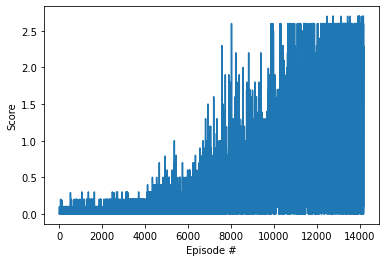

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
env.close()